# ALMA Image Processing

### Boilerplate/setup

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib widget 

In [2]:
from IPython.display import display, HTML, Math
import astropy.constants as consts
import astropy.units as units
from astropy.wcs import WCS
from matplotlib.colors import LogNorm
from spectral_cube import SpectralCube
import regions
import pandas as pd

In [3]:
# ['default', 'garamond', 'dark']
FONT = 'default'

In [4]:
font = {'size'   : 12}
matplotlib.rc('figure',figsize=(6,3.6))
matplotlib.rc('font',**font)
matplotlib.rc('image',interpolation='none') # helps with up-sampled images and pdf files
plt.rcParams['figure.constrained_layout.use'] = True

if FONT == "garamond":
    # slow but looks nice if you have the right tex packages
    plt.rcParams.update({
        "text.usetex": True,
        "text.latex.preamble": "\\usepackage[lf]{ebgaramond}\\usepackage{ebgaramond-maths}",
        "font.family": "EBGaramond"
    })

elif FONT == "dark":
    plt.style.use("dark_background")

In [5]:
from astropy.io import fits
from astropy.coordinates import SkyCoord
from scipy.optimize import curve_fit
from radio_beam import Beam
from radio_beam.beam import NoBeamException
import warnings
import spectral_cube
warnings.filterwarnings(action='ignore', category=spectral_cube.utils.SpectralCubeWarning,
                        append=True)
import astropy.visualization
astropy.visualization.quantity_support()  
import zeustools as zt
import os

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# Main data processing! 
## First let's calculate some useful numbers

In [6]:
1/cosmo.arcsec_per_kpc_proper(1.8275)

<Quantity 8.43689611 kpc / arcsec>

In [7]:
cosmo.lookback_time(1.8275)

<Quantity 9.94984903 Gyr>

In [8]:
cosmo.hubble_time - cosmo.lookback_time(1.8275)

<Quantity 4.01861128 Gyr>

In [9]:
cosmo.luminosity_distance(1.8275)

<Quantity 13912.75258029 Mpc>

In [10]:
cosmo.angular_diameter_distance(1.8275)

<Quantity 1740.23474203 Mpc>

In [11]:
def get_pixel_scale(spectral_cube):
    """ Given a spectral cube, compute the size of a pixel 
    in degrees """
    if spectral_cube.wcs.pixel_scale_matrix[1,0] != 0 or abs(spectral_cube.wcs.pixel_scale_matrix[1,1]) != abs(spectral_cube.wcs.pixel_scale_matrix[0,0]):
        print("Warning: pixel scale is not square")
    a = abs(spectral_cube.wcs.pixel_scale_matrix[1,1])
    return a*units.deg

def get_plot_ellipse(spectral_cube,x,y,color,target_wcs=None):
    """ Given a spectral cube, extract its beam and create an ellipse
    from it. The ellipse will be placed at x,y """
    if type(spectral_cube) is SpectralCube:
        beam = spectral_cube.beam
        wcs = spectral_cube.wcs
    elif type(spectral_cube) is fits.hdu.image.PrimaryHDU:
        beam = Beam.from_fits_header(spectral_cube.header)
        wcs = WCS(spectral_cube.header)
    else:
        raise RuntimeError("Unsupported argument type. We support spectral cubes and fits PrimaryHDUs")
        
    if target_wcs is not None:
        wcs = target_wcs
        
    el = beam.ellipse_to_plot(x,y,wcs.pixel_scale_matrix[1,1]*units.deg)
    el.set_color(color)
    return(el)

def wcsfig(cube,
           elx=100,
           ely=100,
           elc='w',
           pre_el_patches=None,
           axis_labels_dict={
               "dec":['DEC (J2000)',{'minpad':-0.4}],
               "ra":['RA (J2000)',{}]
           }, # This is unwieldy but I think it's the best I've come up with
           **kwargs
          ):
    """ Magic function, which, given a spectral cube, returns a 
    figure and axis that you can use to plot the spectral cube with
    physical coordinates. This also takes care of plotting the 
    beam ellipse if the spectral cube has beam parameters"""
    fig = plt.figure(**kwargs)
    if type(cube) is SpectralCube:
        proj = cube.wcs.dropaxis(2)
    elif type(cube) is fits.hdu.image.PrimaryHDU:
        proj = get_wcs(cube)
    else:
        raise RuntimeError("Unsupported argument type. We support spectral cubes and fits PrimaryHDUs")
    ax = fig.add_subplot(111,projection=proj)
    
    if pre_el_patches is not None:
        if type(pre_el_patches) is list:
            for patch in pre_el_patches:
                ax.add_patch(patch)
        else:
            ax.add_patch(pre_el_patches)
    
    try:
        e = get_plot_ellipse(cube,elx,ely,elc)
        ax.add_patch(e)
    except NoBeamException:
        print("No beam found, not plotting beam ellipse")
    if axis_labels_dict is not None:
        for key in axis_labels_dict:
            ax_transform = ax.coords[key]
            params = axis_labels_dict[key]
            ax_transform.set_axislabel(params[0], **params[1])
    return fig,ax

def get_wcs(fitshdu):
    """ Return a wcs object from a fits HDU object """
    return WCS(fitshdu.header,naxis=["longitude","latitude"])

def total_beams(cube,verbose=False):
    """ Compute the total number of beams in a given spectral cube """
    if verbose:
        print(cube.pixels_per_beam)
        print(np.sum(np.logical_not(np.isnan(cube[0]))))
    return np.sum(np.logical_not(np.isnan(cube[0])))/cube.pixels_per_beam

def two_gaussians(x,peak1,x01,sig1,peak2,x02,sig2):
    """ Return the sum of two gaussians """
    return zt.gaussian(x,sig1,x01,peak1) + zt.gaussian(x,sig2,x02,peak2)

def two_gaussians_integral(peak1,x01,sig1,peak2,x02,sig2,verbose=False):
    """ Compute the integral of the two gaussians fitting function """
    
    i1 = zt.gaussian_integral(sig1,x01,peak1)
    i2 = zt.gaussian_integral(sig2,x02,peak2)
    if verbose:
        print(f"Integral of first gaussian: {i1}")
        print(f"Integral of second gaussian: {i2}")
        print(f"Sum: {i1+i2}")
    return i1+i2

def savefig2(filename,dpi=300):
    """ Extra figure-saver that saves three types of figures that I often use:
    first a png, then two pdfs, one that works well with my LaTeX presentation
    template """

    filename = os.path.join(f"figures_{FONT}",filename)
    try:
        os.mkdir(f"figures_{FONT}")
    except OSError:
        pass
        
    if FONT != 'dark':
        plt.savefig(filename+".png",dpi=dpi,facecolor="#FFFFFF")
        plt.savefig(filename+".pdf",facecolor="#FFFFFF")
    else:
        plt.savefig(filename+".png",dpi=dpi)
    
    if FONT == 'default' or FONT == '':
        plt.savefig(filename+"_latexprez.pdf",facecolor="#EFEFEF")
        #latexfig only needs sans font.



In [12]:
def two_gaussians_integral_error(popt,pcov):
    """ Compute an error estimate for the integrated flux of a 
    two gaussians fitting function from its covariance matrix
    """
    peak1,x01,sig1,peak2,x02,sig2 = popt
    epeak1,ex01,esig1,epeak2,ex02,esig2= np.sqrt(np.diag(pcov))
    
    """
    cov matrix is as follows:
    epeak1        
    cp1 x0       ex01
    cp1f1        cx1f1     ef1
    cp1p2        cx1p2     cf1p2      ep2
    cp1 x2       cx1 x2    cf1 x2     cp2 x2     ex2
    cp1f2        cx1f2     cf1f2      cp2f2      cx2f2     ef2
    
    Lots of these don't contribute anything:
    epeak1        
    -----        -----
    cp1f1        -----     ef1
    cp1p2        -----     cf1p2      ep2
    -----        -----     -----      -----      -----
    cp1f2        -----     cf1f2      cp2f2      -----     ef2
    
    so we have to compute 
    """
    
    cp1s1 = pcov[0,2]
    cp1p2 = pcov[0,3]
    cp1s2 = pcov[0,5]
    cs1p2 = pcov[2,3]
    cs1s2 = pcov[2,5]
    cp2s2 = pcov[3,5]
    # this probably would have been easier to do the matrix math way but at this point
    # it's probably too late
    
    eterms = np.array([sig1*epeak1,
                       peak1*esig1,
                       sig2*epeak2,
                       peak2*esig2,])*np.sqrt(2*np.pi)
    cterms = np.array([peak1*sig1 * cp1s1,
                       sig1*sig2*cp1p2,
                       peak1*peak2*cs1s2,
                       peak2*sig2*cp2s2,
                       sig1*peak2*cp1s2,
                       sig2*peak1*cs1p2,   
                      ]) * 4*np.pi
    print(eterms)
    print(cterms)
    
    
    return np.sqrt(np.sum(eterms**2)+np.sum(cterms))

In [13]:
def extract_region(cube,coord,diameter,ra_unit=units.hourangle,dec_unit=units.deg,dia_unit=units.arcsec):
    """ Given a cube, coordinate, and diameter, extract a circular region 
    from the cube and return a subcube."""
    main_center = SkyCoord(coord,unit=(ra_unit, dec_unit),frame="icrs") #Diameter: 1.45" circle
    main_region = regions.CircleSkyRegion(center=main_center, radius=diameter/2 * dia_unit)
    subcube = cube.subcube_from_regions([main_region])
    return subcube

def getmoment0(cube):
    """ This is a convenience wrapper for cube.moment0()
    It tries to return mJy/beam, but that's not guaranteed"""
    print("Convenience function getmoment0 has destroyed your image's units. It hopefully returned mJy/beam.")
    print(cube.header["CDELT3"],cube.header["NAXIS3"])
    return (cube.moment0()/(cube.header["CDELT3"]*cube.header["NAXIS3"]*units.Hz)*1000).value

def get_ds9_region_rms(cube,ds9regionfile):
    """Given a ds9 region file (probably exported from CASA, regioning system doesn't support casa regions well) 
    compute the RMS of that region, and return (rms, the subcube used).
    Note that the RMS is in Jy/beam"""

    rmsregion=regions.Regions.read(ds9regionfile,format="ds9")
    rmscube = cube.subcube_from_regions(rmsregion)
    print(rmscube.shape)
    return (np.sqrt((rmscube*rmscube).mean(axis=(1,2))),rmscube)

## Define some useful constants

In [14]:
CII_REST = 1900.53690000 * units.GHz
CII_OBS = 672.16159151 * units.GHz

In [15]:
source_size_maj=1/cosmo.arcsec_per_kpc_proper(1.8275)*.501*units.arcsec
source_size_min=1/cosmo.arcsec_per_kpc_proper(1.8275)*.377*units.arcsec
source_area = source_size_maj * source_size_min * np.pi
a = source_area.value

In [16]:
source_area

<Quantity 42.23712527 kpc2>

In [17]:
redshift_assumed = CII_REST/CII_OBS-1
redshift_assumed

<Quantity 1.8275>

In [18]:
CII_REST/(1+1.826)

<Quantity 672.51836518 GHz>

In [19]:
proposal_redshift = 1.826
(consts.c *proposal_redshift**2 + 2 * consts.c * proposal_redshift)/(proposal_redshift**2 + 2 *proposal_redshift + 2)

<Quantity 2.33070168e+08 m / s>

In [20]:
observed_redshift = np.sqrt((consts.c+233433.8*units.km/units.s)/(consts.c-233433.8*units.km/units.s))-1
observed_redshift

<Quantity 1.8346991>

In [21]:
CII_REST/(1+observed_redshift)

<Quantity 670.45454562 GHz>

## [CII] moment 0 map and FIR image

### Load and display [CII] image

In [22]:
line = fits.open('../data/SDSSJ1000_CII_mom0_pbcor.fits')
print(line[0].header["BUNIT"])

Jy/beam.km/s


In [23]:

line[0].header["BUNIT"]='Jy.km/beam.s' 
# fix unit issue... Astropy interprets Jy/beam.km/s as Jy/(beam.km.s) :P :P

In [24]:
linecube = SpectralCube.read(line)

In [25]:
linecube.unit 

Unit("Jy km / (beam s)")

In [26]:
linecube.beam

Beam: BMAJ=0.197964510191856 arcsec BMIN=0.166951629820584 arcsec BPA=54.69491556998 deg

In [27]:
lineimage = line[0].data[0][0]
print(np.max(lineimage))

6.295458


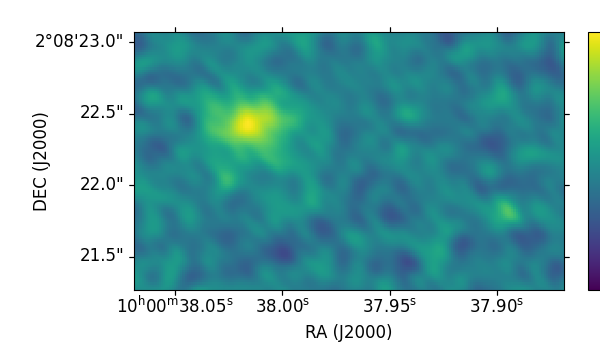

In [28]:
fig,ax=wcsfig(linecube,50,50)#,figsize=(6,3.6))
im=ax.imshow(lineimage,origin="lower")
#fig.tight_layout() # workaround for some weird behavior: this statement can't go after the set_limits
ax.set_ylim(180,300)
ax.set_xlim(200,400)

fig.colorbar(im)

# ax.set_ylabel("test")
# ax.set_xlabel("test2")
#fig.tight_layout()

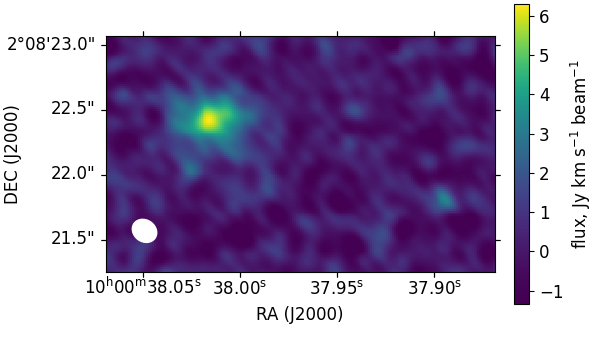

In [29]:
def gamma_configurator(gamma,vmin,vmax,im,fig,n=1000, ticks = None):
    """The standard behavior of matplotlib when using a gamma scale
    is to move the numbers around on the colorbar. If you'd rather
    keep the numbers the same (i.e. linear) while moving the colors
    relative to them, use this function.
    
    We use the "you shouldn't have to use this" argument to 
    `fig.colorbar` called `boundaries` to coax the colorbar
    back to the way I want it
    """
    norm = matplotlib.colors.PowerNorm(gamma=gamma,vmin=vmin, vmax=vmax)
    #norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    im.set_norm(norm)

    b = np.linspace(-1/(2*n-2),1+1/(2*n-2),n+1)
    inv_gamma = b*(vmax-vmin)+vmin
    ticks=ticks or np.arange(round(vmin),round(vmax+1),1)

    cbar=fig.colorbar(im,label="flux, Jy km s$^{-1}$ beam$^{-1}$",boundaries=inv_gamma,ticks=ticks)
    return cbar
    

fig,ax=wcsfig(linecube,220,200)
im=ax.imshow(lineimage,origin="lower")

vmin = np.min(lineimage[180:300,200:400])+1
vmax = np.max(lineimage[180:300,200:400])
cbar=gamma_configurator(1.6,vmin,vmax,im,fig)
# cbar.ax.set_position([0.875,0.12,0.1,0.8])
# fig.tight_layout()
ax.set_xlim(200,400)
ax.set_ylim(179,300)
# ax.set_position([0.17,0.08,0.68,0.9])
savefig2('SDSSJ1000_line_new_colormap')

In [30]:
ax.coords[0].get_axislabel()

'RA (J2000)'

In [31]:
np.std(lineimage[0:200,0:200])

0.9468839

In [32]:
np.mean(lineimage[0:200,0:200])

-0.05859243

In [33]:
linerms,linermscube = get_ds9_region_rms(linecube,"../data/50kms-off-source-spectrum-region.reg")

(1, 88, 86)


In [34]:
rms_cube_2 = extract_region(linecube,"10:00:37.95 +2:08:23.14",1.0)
rms_2 = np.sqrt((rms_cube_2*rms_cube_2).mean())

In [35]:
linerms

<OneDSpectrum [0.68376184] Jy km / (beam s)>

In [36]:
rms_2

<Quantity 0.64459 Jy km / (beam s)>

In [37]:
np.std(rms_cube_2)

<Quantity 0.6375006 Jy km / (beam s)>

### Compute detection limit of diffuse cii extended in 2 arcsec aperture
We assume that the flux recovered $= 0.7 \cdot $ F$_{actual}$ due to maximum recoverable scale issues. Since the region is larger than MRS of one obs and smaller than MRS of other obs.

In [38]:
fcii = 40 #jy km/s assumed missing
reg = 2 # " dia
full_circle_beams = total_beams(extract_region(linecube,"10:00:38.014 +2:08:22.415",reg))
#inner_circle_beams= total_beams(extract_region(linecube,"10:00:38.014 +2:08:22.415",1.2))
beams_in_reg =  full_circle_beams# - inner_circle_beams 

In [39]:
beams_in_reg

83.89767682455411

In [40]:
print(f"{fcii / beams_in_reg * 0.7:.3f} Jy km/(s beam)")

0.334 Jy km/(s beam)


In [41]:
print(f"{fcii / beams_in_reg * 0.7 / linerms.value[0]:.3f} sigma")

0.488 sigma


### Load and display continuum image

In [42]:
cont = fits.open("../data/SDSSJ1000_cont_pbcor.fits")
contcube = SpectralCube.read(cont)

In [43]:
contimage = cont[0].data[0][0]

In [44]:
rms,rmscube = get_ds9_region_rms(contcube,"../data/50kms-off-source-spectrum-region.reg")

(1, 88, 86)


In [45]:
rms

<OneDSpectrum [0.00037049] Jy / beam>

In [46]:
contmainsubcube = extract_region(contcube,"10:00:38.014 +2:08:22.415",0.85)
apertureflux = contmainsubcube.mean(axis=(1,2))
print(apertureflux*total_beams(contmainsubcube))
print(rms*np.sqrt(total_beams(contmainsubcube)))

[0.05388947] Jy / beam
[0.00147117] Jy / beam


In [47]:
total_beams(contmainsubcube)

15.767585258207863

In [48]:
contsatsubcube = extract_region(contcube,"10:00:37.896 +2:08:21.821",0.4)
satapertureflux = contsatsubcube.mean(axis=(1,2))
print(satapertureflux*total_beams(contsatsubcube))
print(rms*np.sqrt(total_beams(contsatsubcube)))

[0.00348814] Jy / beam
[0.00069475] Jy / beam


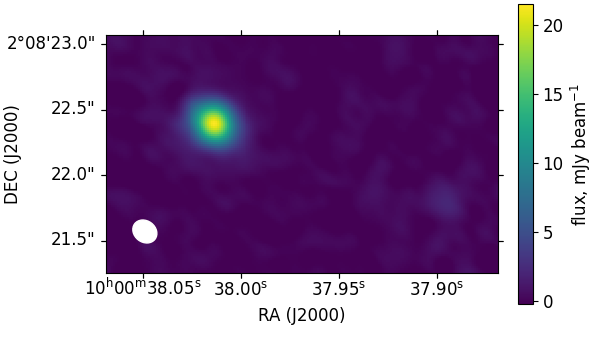

In [49]:
fig,ax=wcsfig(contcube,220,200)
im = ax.imshow(contimage*1000,origin="lower")

vmin = np.min(contimage[180:300,200:400])*1000+1
vmax = np.max(contimage[180:300,200:400])*1000

#gamma_configurator(0.8,vmin,vmax,im,fig,ticks=[0,5,10,15,20])
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
im.set_norm(norm)

cbar=fig.colorbar(im,ticks=[0,5,10,15,20])
cbar.ax.set_ylabel("flux, mJy beam$^{-1}$")
# cbar.ax.set_position([0.875,0.12,0.1,0.8])
# fig.tight_layout()
ax.set_xlim(200,400)
ax.set_ylim(179,300)
# ax.set_position([0.17,0.08,0.68,0.9])

savefig2('SDSSJ1000_continuum')

In [50]:
linecube[:,180:300,200:400]

SpectralCube with shape=(1, 120, 200) and unit=Jy km / (beam s):
 n_x:    200  type_x: RA---SIN  unit_x: deg    range:   150.157791 deg:  150.158621 deg
 n_y:    120  type_y: DEC--SIN  unit_y: deg    range:     2.139242 deg:    2.139737 deg
 n_s:      1  type_s: FREQ      unit_s: Hz     range: 672575368148.732 Hz:672575368148.732 Hz

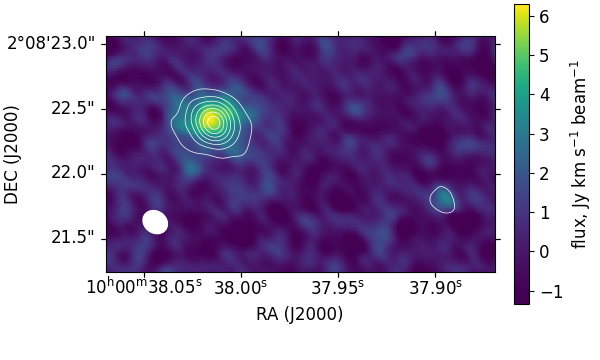

In [51]:
# This is a mess, but it makes the figures align better at the end of the day. (compared to the moment 1 map in paper figure)
# Basically I can't use set_xlim or set_ylim without everything going bonkers.
sub_line = linecube[:,179:300,200:400]
line_data = sub_line.unmasked_data[0].data
fig,ax=wcsfig(sub_line,25,25)#220,200)
im=ax.imshow(line_data,origin="lower")

ax.contour(contimage[179:300,200:400]*1000,levels=np.arange(1.5,21.2,3),colors="w",linewidths=0.5)
vmin = np.min(line_data)+1
vmax = np.max(line_data)
cbar=gamma_configurator(1.6,vmin,vmax,im,fig)
# cbar.ax.set_position([0.875,0.12,0.1,0.8])
# # fig.tight_layout()
# ax.set_position([0.17,0.08,0.68,0.9])
savefig2('SDSSJ1000_line_w_cont')

### quantify offset between cii and continuum

In [52]:
sub_cont=contcube[:,179:300,200:400]
sub_cont

SpectralCube with shape=(1, 121, 200) and unit=Jy / beam:
 n_x:    200  type_x: RA---SIN  unit_x: deg    range:   150.157791 deg:  150.158621 deg
 n_y:    121  type_y: DEC--SIN  unit_y: deg    range:     2.139237 deg:    2.139737 deg
 n_s:      1  type_s: FREQ      unit_s: Hz     range: 669543238154.800 Hz:669543238154.800 Hz

Get index of maximum flux density

In [53]:
np.unravel_index(np.argmax(sub_cont.unmasked_data[0].data,axis=None),sub_cont.shape)

(0, 76, 55)

In [54]:
np.unravel_index(np.argmax(line_data,axis=None), sub_line.shape)

(0, 78, 53)

Use wcs to convert pixel coordinates to actual locations on sky. For some reason the pixel to world wants to see (horiz_coord, vertical_coord, spectral_coord) even though the data file is indexed by (spectral_coord, dec, ra)

In [55]:
cii_loc=sub_line.wcs.pixel_to_world(53,78,0)[0] #WHY IS THE INDEXING BACKWARDS GAAAAAAAA
cont_loc=sub_cont.wcs.pixel_to_world(55,76,0)[0]

In [56]:
sub_cont.wcs.world_axis_units

['deg', 'deg', 'Hz']

In [57]:
print(cii_loc.ra.to_string(unit="deg"))
print(cii_loc.dec.to_string(unit="deg"))

150d09m30.24003139s
2d08m22.42488s


In [58]:
print(cont_loc.ra.to_string(unit="deg"))
print(cont_loc.dec.to_string(unit="deg"))

150d09m30.21001046s
2d08m22.39488s


In [59]:
cont_loc.separation(cii_loc)

<Angle 1.1785113e-05 deg>

Calculate localization significance with $$\sigma_{pos} = \frac{B_{maj}}{max/rms}$$

In [60]:
sub_cont.beam

Beam: BMAJ=0.19490608572958798 arcsec BMIN=0.162827610969528 arcsec BPA=52.60469055176 deg

In [61]:
sub_cont.wcs

WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---SIN' 'DEC--SIN' 'FREQ' 
CRVAL : 150.1583875 2.139558300001 669543238154.8 
CRPIX : 57.0 78.0 1.0 
PC1_1 PC1_2 PC1_3  : 1.0 0.0 0.0 
PC2_1 PC2_2 PC2_3  : 0.0 1.0 0.0 
PC3_1 PC3_2 PC3_3  : 0.0 0.0 1.0 
CDELT : -4.166666666667e-06 4.166666666667e-06 7574325789.895 
NAXIS : 0  0

In [62]:
sub_line.beam

Beam: BMAJ=0.197964510191856 arcsec BMIN=0.166951629820584 arcsec BPA=54.69491556998 deg

In [63]:
sub_line.max()

<Quantity 6.295458 Jy km / (beam s)>

In [64]:
linerms

<OneDSpectrum [0.68376184] Jy km / (beam s)>

In [65]:
contrms = rms # for my own sanity later on

Separation = $0.042 \pm 0.022 ^{\prime\prime}$

### Set a naive cutoff and plot the [CII]/FIR map 
So far we're not worrying about units. 
The cutoff for the line image is 1.4 Jy km/s, which is about 1.5$\sigma$
The cutoff for the continuum image is 0.75 mjy, or about 1.5$\sigma$

In [66]:
ratiomap = lineimage/contimage
ratiomap[lineimage<1.4] = np.nan
ratiomap[contimage<0.00075] = np.nan

### Translate image into sensible units
Most of the data we need is in the fits file from Stacey 2010. The galaxy's redshift and luminosity distance haven't changed since then :)

The `newlfir` is the value that Drew emailed me, based on data from Herschel and older data from Spitzer, scuba, etc.

This integrated flux number of 0.05558 Jy is from drawing a circular aperture around the source.

In [67]:
something,data = fits.open('../data/barecat_oldsources_retyped.fits')
sdss = data.data[-1]
newlfir = 10**12.8 # L_sun
integratedContinuumFlux = 0.05558 # Jy
newlfirupperbound = 10**(12.8+0.02)
newlfirlowerbound = 10**(12.8-0.02)
uperr = newlfirupperbound-newlfir
dwerr = newlfir - newlfirlowerbound
latex_lfir_value = f"${newlfir/10**12:.2f}^{{+{uperr/10**12:.2f} }}_{{-{dwerr/10**12:.2f} }} \\cdot 10^{{12}}$"
display(Math(latex_lfir_value))
print(latex_lfir_value)

<IPython.core.display.Math object>

$6.31^{+0.30 }_{-0.28 } \cdot 10^{12}$


convert things to better units. 
`lineimage` is in Jy km/s, which is a flux value like W m$^{-2}$ Hz$^{-1}$ km s$^{-1}$. divide it by the wavelength in km to remove the km, and the seconds and hz cancel out. To convert to luminosity, multiply flux by 4$\pi$ D$_L$$^2$. The table I got is in cgs units, so D$_L$ was in cm (that's why I divided it by 100). Now that it's in watts, just divide it by L$_{\odot}$. Actually, both images are in "per beam" units, and that only goes away once I divide the two images (since the beam size is the same).  

In other words,

$$\textrm{Ratio [unitless]} = \frac{
F_{\textrm{line}} \textrm{ [W m}^{-2} \textrm{ Hz}^{-1}\textrm{ km s}^{-1}\textrm{]} \cdot 4\pi \left(D_L\textrm{ [m]}\right)^2
}{
\lambda \textrm{ [km]}
} \cdot \left(\frac{
F_{\textrm{cont}} \cdot L_\textrm{FIR}
}{
\sum{F_{\textrm{cont}}}
}\right)^{-1}
$$ 

In [68]:
#OK, the continuum map is in Jy/beam, and the line map is in Jy km/s/beam.
obswavelength = 158e-9*(1+1.8275) # km
lineflux = lineimage*10**-26/obswavelength  # w / m^2
linelum = lineflux*4*np.pi*(sdss['DL']/100)**2 # W
linelumLsun = linelum / consts.L_sun.to("W").value
linelumLsun
linermsLsun = linerms*10**-26/obswavelength*4*np.pi*(sdss['DL']/100)**2/consts.L_sun.to("W").value
linermsLsun = linermsLsun.value
linermsLsun

array([94566306.17916434])

In [69]:
obswavelength = obswavelength * units.km

In [70]:

def jy_km_s_to_lsun(jy_km_s,redshift,restwavelength):
    """ Given a Quantity of Jy km s^-1, return a new
    Quantity containing the equivalent luminosity in
    L_sun. Requires the redshift of the source and the
    rest wavelength of the spectral line observed"""
    obswavelength = (restwavelength*(1+redshift)).to("km",equivalencies = units.spectral())
    wm2 = jy_km_s * 10**-26 * units.watt/units.m**2/units.Jy/obswavelength*units.s
    lum = wm2 * 4 * np.pi * (cosmo.luminosity_distance(redshift))**2
    return lum.to("L_sun")

def jy_km_s_to_lsun_obs(jy_km_s,redshift,obswavelength):
    """ Given a Quantity of Jy km s^-1, return a new
    Quantity containing the equivalent luminosity in
    L_sun. Requires the redshift of the source and the
    telescope-frame wavelength of the spectral line observed"""
    obswavelength = obswavelength.to("km",equivalencies=units.spectral())
    wm2 = jy_km_s * 10**-26 * units.watt/units.m**2/units.Jy/obswavelength*units.s
    lum = wm2 * 4 * np.pi * (cosmo.luminosity_distance(redshift))**2
    return lum.to("L_sun")

def lsun_to_jy_km_s_obs(lsun, redshift, obswavelength):
    obswavelength = obswavelength.to("km",equivalencies=units.spectral())
    lum = lsun.to("W")
    wm2 = lum / 4 / np.pi / cosmo.luminosity_distance(redshift)**2
    jykms = wm2 / (10**-26 * units.watt/units.m**2/units.Jy/obswavelength*units.s)
    return jykms.to("Jy km s-1")

In [71]:
lsun = jy_km_s_to_lsun(4.86 * units.jansky * units.km / units.s,1.8275,obswavelength/2.8275)
lsun_to_jy_km_s_obs(lsun,1.8275,obswavelength)

<Quantity 4.86 Jy km / s>

In [72]:
cii_lsun_sat = jy_km_s_to_lsun(2.3 * units.jansky * units.km / units.s,1.8275,obswavelength/2.8275)
fir_sat = 3.5e-3 /integratedContinuumFlux*newlfir #3.5 mJy, fir_sat and newlfir are in l_sun

In [73]:
print(f"{cii_lsun_sat:.2e} Lsun")

3.11e+08 solLum Lsun


In [74]:
print(f"{fir_sat:.2e} Lsun")

3.97e+11 Lsun


In [75]:
print(f"{cii_lsun_sat/fir_sat:.2e}/ Lsun")

7.84e-04 solLum/ Lsun


In [76]:
consts.L_sun

<<class 'astropy.constants.iau2015.IAU2015'> name='Nominal solar luminosity' value=3.828e+26 uncertainty=0.0 unit='W' reference='IAU 2015 Resolution B 3'>

Converting the continuum flux to L$_{\odot}$ is easier. Simply divide the map by its total integrated flux, and then multiply it by the total FIR flux. 


In [77]:
contFIR = contimage/integratedContinuumFlux*newlfir#sdss['LFIR']
contrmsFIR = contrms/integratedContinuumFlux*newlfir

Now we can just divide the two images by each other to get a ratio map.

In [78]:
ratiomapnormalized = linelumLsun/contFIR
ratiomapnormalized[lineimage<1.4] = np.nan
ratiomapnormalized[contimage<0.00075] = np.nan

<>:5: SyntaxWarning: invalid escape sequence '\c'
<>:5: SyntaxWarning: invalid escape sequence '\c'
/var/folders/ck/hy5p5w_s1l12xprkbrgybk180000gn/T/ipykernel_12794/2830744611.py:5: SyntaxWarning: invalid escape sequence '\c'
  cbar=fig.colorbar(im,label="[CII]/FIR $\cdot 10^3$")


(200.0, 300.0)

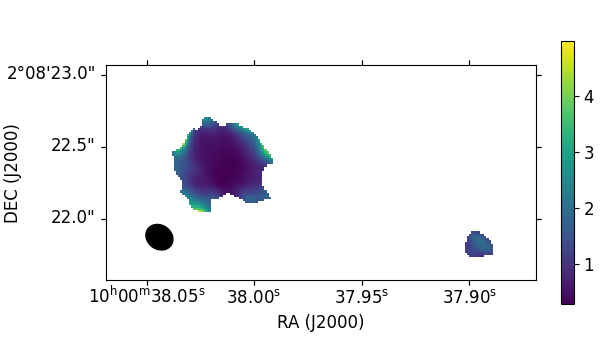

In [79]:
fig,ax=wcsfig(linecube,elx=225,ely=220,elc='k')
im=ax.imshow(ratiomapnormalized*1e3,origin="lower")#, norm=LogNorm())

#im.clim(0.0005,0.004)
cbar=fig.colorbar(im,label="[CII]/FIR $\cdot 10^3$")

# fig.tight_layout()


ax.set_xlim(200,400)
ax.set_ylim(200,300)
# cbar.ax.set_position([0.875,0.12,0.1,0.8])
# ax.set_position([0.17,0.08,0.68,0.9])

### Make [CII]/FIR Image with "contiguous positive region" method

In [80]:
from scipy import ndimage

`scipy.ndimage.label` finds contiguous regions of nonzero data and labels them.

In [81]:
def contiguous_regions(image,coordinates,threshold=0,do_plots=False):
    """
    parameters: image: a 2d image numpy array
                coordinates: a list of 2-tuples for points that you want to extract around. Note these are x,y NOT standard numpy order.
                threshold: value below which constitutes a "Cut"
                do_plots: boolean, whether to show all the debug plots
    returns:
                a 2d image numpy array, with everything zeroed except for contiguous above-threshold regions around the supplied coordinates"""
    im_tolabel = image.copy()
    im_tolabel[im_tolabel<threshold] = 0
    im_labeled = ndimage.label(im_tolabel)[0]
    if do_plots:
        imshow(im_tolabel,origin='lower')
        title("original image, with thresholds applied")
        show()
        imshow(im_labeled,origin='lower')
        title("image regions")
    output_image = np.zeros_like(image)
    for coord in coordinates:
        label_number = im_labeled[coord[1],coord[0]]
        region = im_labeled == label_number
        if do_plots:
            imshow(region,origin='lower')
            title(f"component region centered around {coord}")
            show()
        output_image[region] = image[region]
    if do_plots:
        imshow(output_image,origin='lower')
        title("final image")
        show()
    return output_image

Get the standard deviation of a region of the image in lsun. Since we've already converted these two images to Lsun, we can just take the standard deviation

In [82]:
print(f"{np.std(linelumLsun[0:200,0:200]):.2e}")
print(f"{np.std(contFIR[0:200,0:200]):.2e}")

1.31e+08
5.54e+10


The reviewer asks for these values in surface brightness units, 

In [83]:
contFIR

array([[ 1.80227424e+11,  1.84691081e+11,  1.73954056e+11, ...,
         4.28910822e+09,  1.75539016e+10,  3.00138680e+10],
       [ 1.88466807e+11,  1.86915406e+11,  1.69644573e+11, ...,
        -4.45196851e+09,  6.01635738e+09,  1.65071329e+10],
       [ 1.77611096e+11,  1.70086007e+11,  1.47828949e+11, ...,
        -1.40223816e+10, -6.41609216e+09,  1.91285606e+09],
       ...,
       [ 1.20616804e+11,  9.39327734e+10,  6.71217500e+10, ...,
         1.50157069e+09,  2.18601001e+10,  3.98873682e+10],
       [ 1.58658986e+11,  1.31326591e+11,  1.03292772e+11, ...,
        -2.22137528e+10, -9.58422016e+09, -1.16251880e+08],
       [ 1.82466380e+11,  1.55148386e+11,  1.26250435e+11, ...,
        -4.65001718e+10, -4.24183439e+10, -4.06983434e+10]], dtype=float32)

In [84]:
linelum_contiguous=contiguous_regions(linelumLsun,[[250,250],[375,215]],1.3e8)

In [85]:
FIR_contiguous=contiguous_regions(contFIR,[[250,250],[375,215]],5e10)

In [86]:
linelum_contiguous[linelum_contiguous==0]=np.nan
FIR_contiguous[FIR_contiguous==0]=np.nan
ciitofir = linelum_contiguous/FIR_contiguous


In [87]:
np.save("fir_contiguous_image_lsun.npy",FIR_contiguous)

In [88]:
np.save("cii_contiguous_image_lsun.npy",linelum_contiguous)

/var/folders/ck/hy5p5w_s1l12xprkbrgybk180000gn/T/ipykernel_12794/148246775.py:109: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  plt.savefig(filename+".png",dpi=dpi,facecolor="#FFFFFF")
/var/folders/ck/hy5p5w_s1l12xprkbrgybk180000gn/T/ipykernel_12794/148246775.py:109: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  plt.savefig(filename+".png",dpi=dpi,facecolor="#FFFFFF")


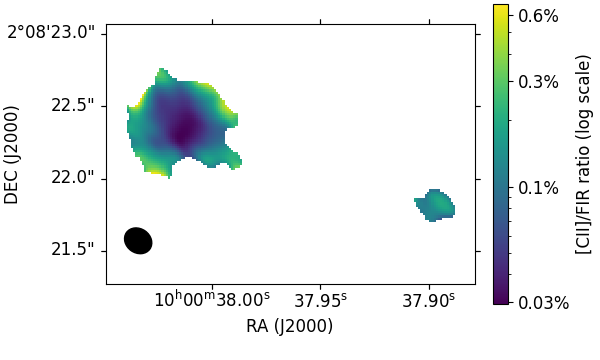

In [89]:
fig,ax=wcsfig(linecube,elx=235,ely=200,elc='k')
im=ax.imshow(ciitofir,origin="lower", norm=LogNorm())


cb=fig.colorbar(im,ticks=[3*10**-4,10**-3,3*10**-3,6*10**-3])
cb.ax.set_yticklabels(['0.03%', '0.1%', '0.3%', '0.6%']) 
cb.ax.set_ylabel("[CII]/FIR ratio (log scale)")

ax.set_xlim(220,390)
ax.set_ylim(180,300)
# cb.ax.set_position([0.84,0.12,0.1,0.8])
# ax.set_position([0.17,0.08,0.65,0.9])
savefig2("SDSSJ1000_CII_FIR")

In [90]:
ratio_values=np.load("../data/pdrt_model_cii_fir.npy")
g_values_log_erg = np.load("../data/pdrt_model_log_erg_axis_coords.npy")


In [91]:
good_ratios = ratio_values[12:][::-1]
good_gs_log_erg = g_values_log_erg[12:][::-1]

In [92]:
good_ratios

array([2.72077978e-06, 3.26484246e-06, 4.13923226e-06, 5.35529216e-06,
       6.91579635e-06, 8.92581829e-06, 1.14574204e-05, 1.45654340e-05,
       1.84780838e-05, 2.34931267e-05, 2.99679996e-05, 3.83885017e-05,
       4.92211148e-05, 6.30355571e-05, 8.06198368e-05, 1.02973754e-04,
       1.31349792e-04, 1.67293125e-04, 2.12740080e-04, 2.70009274e-04,
       3.42009909e-04, 4.32355766e-04, 5.45455143e-04, 6.86576765e-04,
       8.61787586e-04, 1.07856595e-03, 1.34562573e-03, 1.67322543e-03,
       2.07396969e-03, 2.56080064e-03, 3.14894528e-03, 3.85352969e-03,
       4.68988437e-03, 5.67180617e-03, 6.80710934e-03, 8.09955038e-03,
       9.53777507e-03, 1.10960528e-02, 1.27290217e-02, 1.43651916e-02,
       1.59189999e-02, 1.72987562e-02, 1.84060633e-02, 1.91375557e-02,
       1.94296036e-02], dtype='>f4')

In [93]:
good_gs_erg = 10**good_gs_log_erg
good_gs_habing = good_gs_erg/1.6e-3

In [94]:
(good_gs_erg*units.erg/units.s/units.cm**2).to("Lsun/kpc**2").unit

Unit("solLum / kpc2")

In [95]:
g_lsun=(good_gs_erg*units.erg/units.s/units.cm**2).to("Lsun/kpc**2").value

In [96]:
g0map = np.interp(ciitofir, good_ratios, good_gs_habing)
g0map_no_nans = g0map.copy()
g0map_no_nans[np.isnan(g0map)]=0

In [97]:
np.unravel_index(np.argmax(g0map_no_nans,axis=None),g0map.shape)


(248, 254)

In [98]:
g0loc=linecube.wcs.pixel_to_world(254,248,0)[0]
g0loc.separation(cont_loc)

<Angle 2.94627825e-05 deg>

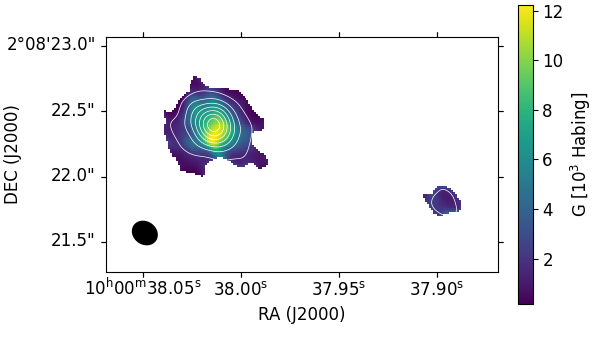

In [99]:
fig,ax=wcsfig(linecube,elx=220,ely=200,elc='k')
im=ax.imshow(g0map*1e-3,origin="lower")#, norm=LogNorm())


cb=fig.colorbar(im)#,ticks=[3*10**-4,10**-3,3*10**-3,6*10**-3])
#cb.ax.set_yticklabels(['0.03%', '0.1%', '0.3%', '0.6%']) 
cb.ax.set_ylabel("G [$10^3$ Habing]")
# ax.set_title("FUV field map#, assuming $n=10^4$ cm$^{-1}$")
ax.contour(contimage*1000,levels=np.arange(1.5,21.2,3),colors="w",linewidths=0.5)
ax.set_xlim(200,400)
ax.set_ylim(180,300)
# cb.ax.set_position([0.875,0.12,0.1,0.8])
# ax.set_position([0.17,0.08,0.68,0.9])
savefig2("SDSSJ1000_fuv_map")

naively say it's all coming from b0 stars? known conversion from photons kennicutt 1990
also murphy 2009

(200.0, 300.0)

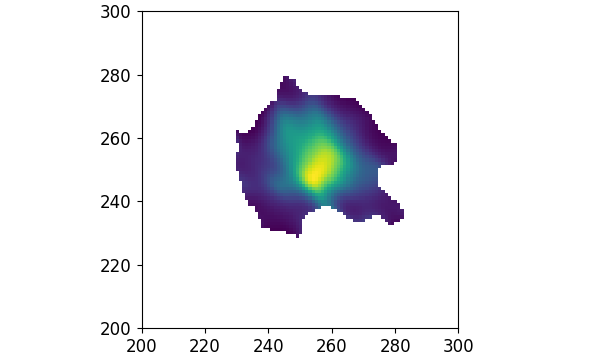

In [100]:
plt.figure()
plt.imshow(g0map.data)
ax=plt.gca()
plt.ylim(200,300)
plt.xlim(200,300)

In [101]:
ellipse_positions = [
    (243,237),
    (255,237),
    (267,237),
    (279,237),
    (247,247),
    (235,247),
    (259,247),
    (271,247),
    (239,257),
    (251,257),
    (263,257),
    (275,257),
    (243,267),
    (255,267),
    (267,267),
    (247,277)
    
]
offsetx=-5
offsety=2
for x,y in ellipse_positions:
    el = linecube.beam.ellipse_to_plot(x+offsetx,y+offsety,linecube.wcs.pixel_scale_matrix[1,1]*units.deg)
    el.set_alpha(0.5)
    el.set_facecolor("r")
    ax.add_patch(el)

## scatter plot cii/fir vs fir

In [102]:
dist = cosmo.angular_diameter_distance(observed_redshift)
kpc2_per_beam=linecube.beam.beam_projected_area(dist).to("kpc^2").value

In [103]:
px_scale=get_pixel_scale(linecube)

In [104]:
linecube.beam

Beam: BMAJ=0.197964510191856 arcsec BMIN=0.166951629820584 arcsec BPA=54.69491556998 deg

In [105]:
linecube.beam.beam_projected_area(dist).to("kpc^2")*len(ellipse_positions)

<Quantity 42.62880867 kpc2>

In [106]:
linecube.beam.major/px_scale

<Quantity 13.19763401>

In [107]:
linecube.beam.minor/px_scale

<Quantity 11.13010865>

In [108]:
sfrd = contFIR / kpc2_per_beam * 1.71e-10 * 2 #( extra 2 is because they defined lFIR as 8-1000 um
g_sfr = g_lsun *1.71e-10 * 2 * 2 #only half of the FIR is from G; they define Lfir differently

In [109]:
sparse_sfrd = []
sparse_ciifir = []
sparse_sfrd_err = []
sparse_ciifir_err = []
########################
##########################
for px in ellipse_positions:
    if sfrd[px] > 0: #########
        ########################
        ##########################
        sparse_sfrd.append(sfrd[px])
        # ok I'll stop
        sparse_ciifir.append(ciitofir[px])
        sparse_sfrd_err.append(sfrd[px] * contrms.value/contimage[px])
        

16 13


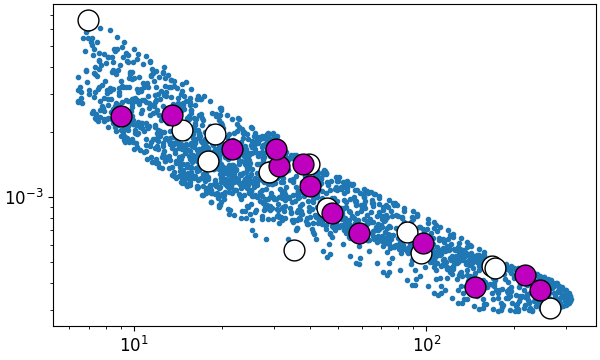

In [110]:

sparse_sfrd2 = []
sparse_ciifir2 = []
sparse_sfrd_err = []
sparse_ciifir_err = []
for px in ellipse_positions:
    if sfrd[px[0]+offsetx,px[1]+offsety] > 0 and np.isfinite(ciitofir[px[0]+offsetx,px[1]+offsety]):
        o_px = (px[0]+offsetx, px[1]+offsety)
        sparse_sfrd2.append(sfrd[o_px])
        sparse_ciifir2.append(ciitofir[o_px])
        cont_rel_err = contrms.value/contimage[o_px]
        sparse_sfrd_err.append(sfrd[o_px] * cont_rel_err) 
        cii_rel_err = linerms.value/lineimage[o_px]
              
        sparse_ciifir_err.append(ciitofir[o_px]*np.sqrt(cont_rel_err**2+cii_rel_err**2))
        
sparse_ciifir2 = np.array(sparse_ciifir2)
plt.figure()
plt.loglog(sfrd.flatten(),ciitofir.flatten(),'.')
plt.loglog(sparse_sfrd,sparse_ciifir,'o',c='w',markeredgecolor='k',markersize=15)
plt.loglog(sparse_sfrd2,sparse_ciifir2,'o',c='m',markeredgecolor='k',markersize=15)
print(len(sparse_sfrd),len(sparse_sfrd2))

Magenta circles correspond better to the density of points in the oversampled array (blue) than white does. So we use magenta at the end of the day

In [111]:
sparse_sfrd_err=np.array(sparse_sfrd_err).flatten()
sparse_ciifir_err=np.array(sparse_ciifir_err).flatten()

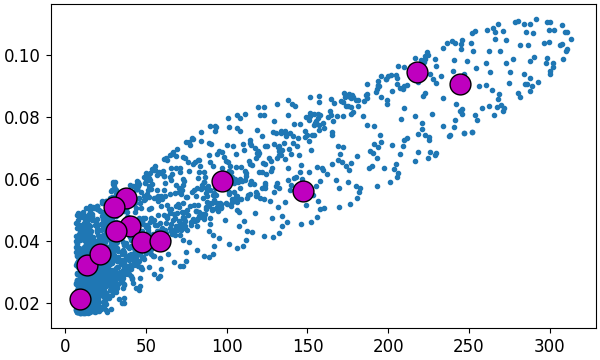

In [112]:
plt.figure()
plt.plot(sfrd.flatten(),ciitofir.flatten()*sfrd.flatten(),'.')
#plt.loglog(sparse_sfrd,sparse_ciifir,'o',c='w',markeredgecolor='k',markersize=15)
plt.plot(sparse_sfrd2,np.array(sparse_ciifir2)*np.array(sparse_sfrd2),'o',c='m',markeredgecolor='k',markersize=15)

In [113]:
foo=pd.read_csv("../data/fulloforions.csv",header = [0],skiprows=1)

shallower slopes correspond to diffuse fields

In [114]:
def g_to_lsun(g_habing):
    return (g_habing*1.6e-6*units.W/units.m**2).to("Lsun/kpc^2").value * 2 #half of 
    # the FIR luminosity is from UV

def lsun_to_sfrsd(lsun_kpc2):
    return lsun_kpc2 * 1.71e-10 * 2 # original formula used TIR, I use FIR

def sfrsd_to_lsun(sfrsd):
    return sfrsd / 1.71e-10 / 2

def lsun_to_g_habing(lsun):
    return (lsun * units.Lsun/units.kpc**2).to("W/m^2").value /1.6e-6 /2

def sfrsd_to_g(sfrsd):
    return lsun_to_g_habing(sfrsd_to_lsun(sfrsd))

def g_to_sfrsd(g):
    return lsun_to_sfrsd(g_to_lsun(g))

In [115]:
f"{lsun_to_sfrsd(g_to_lsun(1000)):.2e}"

'2.72e+00'

In [116]:
lsun_to_g_habing(g_to_lsun(1))

1.0000000000000002

In [117]:
(8.4e10*units.Lsun/units.kpc**2).to("W/m^2").value /1.6e-6

21107.1765146911

In [118]:
lsun_to_g_habing(8.4e10)

10553.58825734555

In [119]:
sfrsd_to_lsun(lsun_to_sfrsd(1))

1.0

In [120]:
sfrsd_to_g(g_to_sfrsd(1))

1.0000000000000002

/var/folders/ck/hy5p5w_s1l12xprkbrgybk180000gn/T/ipykernel_12794/3856555044.py:72: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  plt.scatter(SigmaSFR_GOALS, Ratio_GOALS,  c = '1', marker = 's', edgecolor = 'darkorange', facecolor = '0.5', s = 30, zorder = 2,label = 'GOALS')
/var/folders/ck/hy5p5w_s1l12xprkbrgybk180000gn/T/ipykernel_12794/3856555044.py:95: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  plt.scatter(SigmaSFR_SDP11, Ratio_SDP11,  c = 'cyan', marker = 'o', edgecolor = 'darkblue', facecolor = '0.5', s = 30, zorder = 6, label = 'Lamarche+ 2018')
/var/folders/ck/hy5p5w_s1l12xprkbrgybk180000gn/T/ipykernel_12794/3856555044.py:98: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior

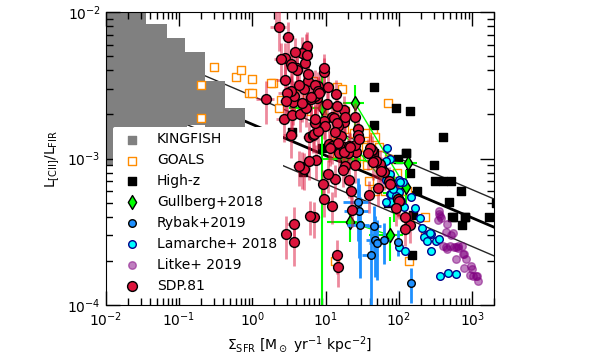

In [121]:

# Load SDP.81 data. I only included the datapoints with [CII]/FIR and Sigma_SFR measured at >3sigma confidence.
SDP81_Sigma_SFR, SDP81_Ratio, SDP81_Sigma_SFR_sigma, SDP81_Ratio_sigma = np.loadtxt('../data/sdp81.data', unpack=True)


#  Rybak+2019a resolved measurements - ALESS 49.1 and 57.1
SigmaSFR_49_1_Data, LCII, LFIR, Ratio_49_1_Data, RMS_Ratio_49 = np.loadtxt('../data/table_aless_49_new_140mas.data', unpack=True)
SigmaSFR_57_1_Data, LCII, LFIR, Ratio_57_1_Data, RMS_Ratio_57 = np.loadtxt('../data/table_aless_57_new_140mas.data', unpack=True)
#uncertainties on Sigma_SFR
RMS_Sigma_49 =  10.5
RMS_Sigma_57 =  10.1


# Load data from Lamarche+2018 and Litke+2019
SigmaSFR_SDP11, Ratio_SDP11 = np.loadtxt('../data/Lamarche_SDP11_original.data', unpack=True)
SigmaSFR_SDP11 = 10.**SigmaSFR_SDP11    # convert from log to linear
Ratio_SDP11 = 10.**Ratio_SDP11  # convert from log to linear
SigmaSFR_Litke, Ratio_Litke, SNR_Litke = np.loadtxt('../data/Litke2019_CII_FIR_original.data', unpack=True)

# and purge Litke+2019 datapoints: many of them have S/N<1! (not clear from their original paper)
SigmaSFR_Litke[SNR_Litke<3]=np.nan
Ratio_Litke[SNR_Litke<3]=np.nan
SigmaSFR_Litke = 1.71e-10*10**SigmaSFR_Litke
Ratio_Litke = 10**Ratio_Litke   # convert from log to linear

# Gullberg+2018 sample
SigmaSFR_Gullberg=[8.9, 86.1, 25.1, 122.9, 18.0, 134.6, 21.4, 76.0]
Ratio_Gullberg=[0.0022, 0.00058, 0.0024, 0.00064, 0.00099, 0.00093, 0.00037, 0.00030]
SigmaSFR_Gullberg_STD=[5.7,25,8,21.5,11,44,11,37]
Ratio_Gullberg_STD=[0.0021,0.00021,0.0008,0.0002,0,0,0.0001,0.0001]

# load "others" data from Gullberg+2018
SigmaSFR_GOALS, Ratio_GOALS = np.loadtxt('../data/gullberg2018_GOALS.data', unpack=True)
SigmaSFR_HighZ_2, Ratio_HighZ_2 = np.loadtxt('../data/gullberg2018_smg+qso.data', unpack=True)

# Kingfish sample from Smith+2017
SigmaSFR_Kingfish, Ratio_Kingfish = np.loadtxt('../data/smith2017.data', unpack=True)

#High-z sample from Smith+2017 figure
# Sigma_SFR
SigmaSFR_HighZ = np.asarray([3.5,9,58,156,152,734,483,4.9])
# [CII]/FIR (% !!!!!)
Ratio_HighZ = np.asarray([0.153,0.119,0.088,0.0416,0.022,0.0354,0.051,0.081])


# generate the data for models: Munoz & Oh 2016, Smith+2017
SigmaSFRSequence = np.linspace(0.001,5000.,num=999)
Smith2017 = 1./583.4*(SigmaSFRSequence)**(-1./4.7)
MunozOh16 = 2.2e-3*0.13/0.13*(SigmaSFRSequence/0.886/(np.pi*0.16*0.12*7.9**2/4.0))**(-0.5)

fig = plt.figure()
ax=fig.add_subplot(111)

plt.xlabel(r'$\Sigma_\mathrm{SFR}$ [M$_\odot$ yr$^{-1}$ kpc$^{-2}$]', color = 'black', fontsize = 10)
plt.ylabel(r'L$_{\mathrm{[CII]}}$/L$_{\mathrm{FIR}}$', color = 'black', fontsize = 10)
plt.tick_params(axis='both', which = 'major', length = 10, width=1, color = 'black', direction = 'in', labelsize = 10)
plt.tick_params(axis='both', which = 'minor', length = 5, width=1, color = 'black', direction = 'in', labelsize = 10)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.set_xscale('log')
ax.set_yscale('log')

plt.xlim(1.e-2,2.e3)
plt.ylim(1.e-4,1.e-2)

# plot Smith+2017 trend + 1-sigma scatter
plt.plot(SigmaSFRSequence, Smith2017, color = '0', lw=2, zorder = 1)
plt.plot([0.00049,2427.9], [0.01358, 0.000508], lw = 1, color = '0.15', zorder = 1)
plt.plot([0.00049,2427.9], [0.00561, 0.000208], lw = 1, color = '0.15', zorder = 1)

plt.scatter([1e-6],[1e-6], s = 30, color = '0.5', marker = "s", zorder = 1, label = 'KINGFISH')

plt.scatter(SigmaSFR_GOALS, Ratio_GOALS,  c = '1', marker = 's', edgecolor = 'darkorange', facecolor = '0.5', s = 30, zorder = 2,label = 'GOALS')
plt.scatter(SigmaSFR_HighZ_2, Ratio_HighZ_2, c = '0', marker = "s",  s = 30, zorder = 2)

# Smith+2017 values are in %!
plt.scatter(SigmaSFR_HighZ, Ratio_HighZ/100, c = '0', marker = "s",  s = 30, zorder = 2,label = 'High-z')
plt.fill(SigmaSFR_Kingfish, Ratio_Kingfish/100., "0.5")

for i in range(4):
    plt.plot([SigmaSFR_Gullberg[2*i],SigmaSFR_Gullberg[2*i+1]], [Ratio_Gullberg[2*i],Ratio_Gullberg[2*i+1]], color = 'lime', lw=1, zorder = 2)

plt.errorbar(SigmaSFR_Gullberg, Ratio_Gullberg, xerr = SigmaSFR_Gullberg_STD,  yerr = Ratio_Gullberg_STD, color = 'lime', fmt = '.', zorder = 2)
plt.scatter(SigmaSFR_Gullberg, Ratio_Gullberg,  c = 'lime', marker = "d", edgecolor = '0', s = 50, zorder = 3,label = 'Gullberg+2018')

plt.errorbar(SigmaSFR_49_1_Data, Ratio_49_1_Data, xerr = RMS_Sigma_49,  yerr = RMS_Ratio_49, color = 'dodgerblue', fmt = '.', lw=2, zorder = 3)
plt.scatter(SigmaSFR_49_1_Data, Ratio_49_1_Data, c = 'dodgerblue', edgecolor = '0', s = 30, zorder = 10, label = 'Rybak+2019')
plt.errorbar(SigmaSFR_57_1_Data, Ratio_57_1_Data, xerr = RMS_Sigma_57, yerr = RMS_Ratio_57, color = 'dodgerblue', fmt = '.', lw=2, zorder = 3)
plt.scatter(SigmaSFR_57_1_Data, Ratio_57_1_Data, c = 'dodgerblue', edgecolor = '0', s = 30, zorder = 10)

sigmaSFR_r19 = np.append(SigmaSFR_49_1_Data, SigmaSFR_57_1_Data)
ratio_r19 = np.append(Ratio_49_1_Data, Ratio_57_1_Data)
sigmaSFR_r19_err = np.append(RMS_Sigma_49, RMS_Sigma_57)
ratio_r19_err = np.append(RMS_Ratio_49, RMS_Ratio_57)

plt.scatter(SigmaSFR_SDP11, Ratio_SDP11,  c = 'cyan', marker = 'o', edgecolor = 'darkblue', facecolor = '0.5', s = 30, zorder = 6, label = 'Lamarche+ 2018')

#Litke+2019 - plot only 1 in 4 points
plt.scatter(SigmaSFR_Litke[::4], Ratio_Litke[::4],  c = 'purple', alpha = 0.5, marker = 'o', edgecolor = 'purple', facecolor = 'purple', s = 30, zorder = 6, label = 'Litke+ 2019')


#SDP.81 - plot only 1 in 4 points
plt.errorbar(SDP81_Sigma_SFR.flatten()[::4], SDP81_Ratio.flatten()[::4],  xerr = SDP81_Sigma_SFR_sigma.flatten()[::4], yerr = SDP81_Ratio_sigma.flatten()[::4], color = 'crimson', alpha=0.5, fmt = '.', lw=2, zorder = 3)
plt.scatter(SDP81_Sigma_SFR.flatten()[::4], SDP81_Ratio.flatten()[::4], c = 'crimson', edgecolor = '0', s = 50, zorder = 10, label = 'SDP.81')


plt.legend(fontsize = 10, loc = 'lower left', edgecolor = 'none', scatterpoints = 1, framealpha = 1)

ax.set_aspect(2)
fig.savefig("comparison_rybak2019c.png", dpi = 150, bbox_inches = 'tight')


In [122]:
ratio_r19_err

array([1.24776815e-04, 2.30976685e-04, 1.15360513e-04, 3.83144325e-05,
       1.30396084e-04, 2.30719596e-04, 1.22535811e-04, 1.98453015e-04,
       8.47220358e-05, 5.55961604e-05])

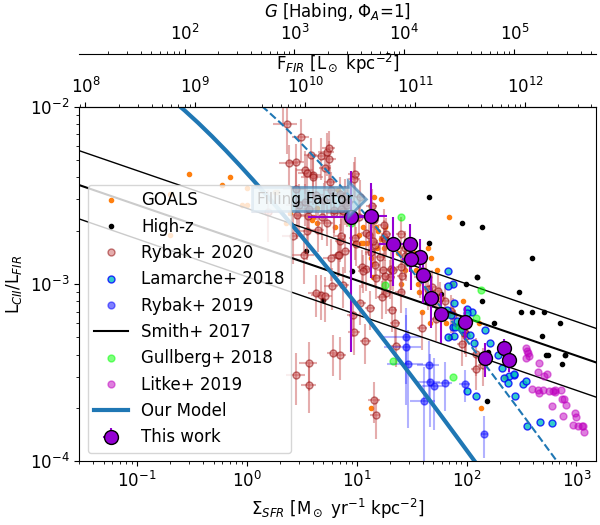

In [123]:
if FONT != 'dark':
    fig = plt.figure(figsize=(6,5.25))
    ax = fig.add_subplot(111)
    
    plt.ylim((1e-4,1e-2))
    plt.xlim((3e-2,1.5e3))
    med_markersize=10
    # The secondary axis makes this plot really slow so don't use it when making more rapid edits
    xax_2 = ax.secondary_xaxis(
        "top", functions = (sfrsd_to_lsun, lsun_to_sfrsd))
    xax_2.set_xlabel("F$_{FIR}$ [L$_\\odot$ kpc$^{-2}$]",labelpad=5)
    xax_3 = ax.secondary_xaxis(
        1.15, functions = (sfrsd_to_g, g_to_sfrsd))
    xax_3.set_xlabel("$G$ [Habing, $\\Phi_A$=1]",labelpad=5)
    
    # plt.loglog(sfrd.flatten(),ciitofir.flatten(),'.',alpha=0.3) #plot every pixel in the image for a wildly oversampled scatter plot.
    # Good for making sure that the resulting samples are representative.
    ax.loglog(SigmaSFR_GOALS, Ratio_GOALS,'.',c='tab:orange',label="GOALS")
    ax.loglog(SigmaSFR_HighZ, Ratio_HighZ/100,'.',c='k',label="High-z")
    ax.loglog(SigmaSFR_HighZ_2, Ratio_HighZ_2,'.',c='k')
    ax.errorbar(SDP81_Sigma_SFR.flatten()[::4], SDP81_Ratio.flatten()[::4],  xerr = SDP81_Sigma_SFR_sigma.flatten()[::4], yerr = SDP81_Ratio_sigma.flatten()[::4], fmt="none", c='indianred',markersize=15, markeredgecolor="darkred",alpha=0.5)
    ax.loglog(SDP81_Sigma_SFR.flatten()[::4], SDP81_Ratio.flatten()[::4], ".", c='indianred',markersize=med_markersize,label="Rybak+ 2020",markeredgecolor="darkred",alpha=0.5)
    
    ax.loglog(SigmaSFR_SDP11, Ratio_SDP11,'.',c='c',markersize=med_markersize,label="Lamarche+ 2018",markeredgecolor="b",alpha=0.8)
    ax.errorbar(sigmaSFR_r19,ratio_r19,xerr=sigmaSFR_r19_err[0], yerr=ratio_r19_err, fmt = 'none', c='blue',markersize=med_markersize,alpha=0.3)
    ax.loglog(sigmaSFR_r19,ratio_r19,'.',c='blue', label="Rybak+ 2019",markersize=med_markersize,alpha=0.5)
    # plt.loglog(foo["X.3"],foo["Y.3"],'-',c='k',label="Kingfish") #Kingfish is pretty far from our region of this parameter space
    ax.loglog([0.00049,2427.9], [0.00561, 0.000208],'-',c='k',linewidth=1)
    
    ax.loglog([0.00049,2427.9], [0.01358, 0.000508],'-',c='k',linewidth=1)
    ax.loglog(SigmaSFRSequence, Smith2017,'-',c='k',label="Smith+ 2017")
    
    ax.loglog(SigmaSFR_Gullberg, Ratio_Gullberg,'.',c='lime',label="Gullberg+ 2018",markersize=med_markersize,alpha=0.5)
    
    ax.loglog(SigmaSFR_Litke[::4], Ratio_Litke[::4],'.',c='m',label="Litke+ 2019",markersize=med_markersize,alpha=0.5)
    ax.errorbar(sparse_sfrd2,sparse_ciifir2,xerr=sparse_sfrd_err,yerr=sparse_ciifir_err,fmt='.',c='darkviolet',markeredgecolor='k',markersize=20,label="This work")
    ax.loglog(g_sfr,good_ratios,label="Our Model",linewidth=3)
    ax.loglog(g_sfr*4.2*4/3,good_ratios,linestyle="--",c="C0") # 4.2 is the derived filling factor, 4/3 accounts for CII ion fraction in the pdr model which is not applied to the data here
    
    ax.set_xlabel("$\\Sigma_{SFR}$ [M$_\\odot$ yr$^{-1}$ kpc$^{-2}$]")
    ax.set_ylabel("L$_{CII}$/L$_{FIR}$")
    ax.text(3.4,0.003, "Filling Factor", ha="center", va="center", size=11, 
            bbox=dict(boxstyle="rarrow,pad=0.3",
                      fc="lightblue", ec="steelblue", lw=2, alpha=0.7))
    
    
    #ax.plot([0.03713646574273769,6812.920690579622],[0.05065321855519537,0.00011761445611505281],label="Munoz&Oh2016")
    #plt.plot([0.1,1,10,100,1000],np.array([1/0.1,1/1,1/10,1/100,1/1000])*0.03)
    
    plt.legend()

In [124]:
x_mo = np.logspace(-1,3,100)
y_mo = 2.2e-3 * (sfrsd_to_lsun(x_mo)/1e11)**(-0.6)
plt.plot(x_mo,y_mo)

In [137]:
if FONT == 'dark':
    fig = plt.figure(figsize=(6,5.25))
    ax = fig.add_subplot(111)
    
    plt.ylim((1e-4,1e-2))
    plt.xlim((3e-2,1.5e3))
    med_markersize=10
    # The secondary axis makes this plot really slow so don't use it when making more rapid edits
    xax_2 = ax.secondary_xaxis(
        "top", functions = (sfrsd_to_lsun, lsun_to_sfrsd))
    xax_2.set_xlabel("F$_{FIR}$ [L$_\\odot$ kpc$^{-2}$]",labelpad=5)
    xax_3 = ax.secondary_xaxis(
        1.15, functions = (sfrsd_to_g, g_to_sfrsd))
    xax_3.set_xlabel("$G$ [Habing, $\\Phi_A$=1]",labelpad=5)
    
    # plt.loglog(sfrd.flatten(),ciitofir.flatten(),'.',alpha=0.3) #plot every pixel in the image for a wildly oversampled scatter plot.
    # Good for making sure that the resulting samples are representative.
    ax.loglog(SigmaSFR_GOALS, Ratio_GOALS,'.',c='tab:orange',label="GOALS")
    ax.loglog(SigmaSFR_HighZ, Ratio_HighZ/100,'.',c='w',label="High-z")
    ax.loglog(SigmaSFR_HighZ_2, Ratio_HighZ_2,'.',c='w')
    ax.errorbar(SDP81_Sigma_SFR.flatten()[::4], SDP81_Ratio.flatten()[::4],  xerr = SDP81_Sigma_SFR_sigma.flatten()[::4], yerr = SDP81_Ratio_sigma.flatten()[::4], fmt="none", c='indianred',markersize=15, markeredgecolor="darkred",alpha=0.5)
    ax.loglog(SDP81_Sigma_SFR.flatten()[::4], SDP81_Ratio.flatten()[::4], ".", c='indianred',markersize=med_markersize,label="Rybak+ 2020",markeredgecolor="darkred",alpha=0.5)
    
    ax.loglog(SigmaSFR_SDP11, Ratio_SDP11,'.',c='c',markersize=med_markersize,label="Lamarche+ 2018",markeredgecolor="b",alpha=0.8)
    ax.errorbar(sigmaSFR_r19,ratio_r19,xerr=sigmaSFR_r19_err[0], yerr=ratio_r19_err, fmt = 'none', c='lightblue',markersize=med_markersize,alpha=0.3)
    ax.loglog(sigmaSFR_r19,ratio_r19,'.',c='lightblue', label="Rybak+ 2019",markersize=med_markersize,alpha=0.5)
    # plt.loglog(foo["X.3"],foo["Y.3"],'-',c='k',label="Kingfish") #Kingfish is pretty far from our region of this parameter space
    ax.loglog([0.00049,2427.9], [0.00561, 0.000208],'-',c='w',linewidth=1)
    
    ax.loglog([0.00049,2427.9], [0.01358, 0.000508],'-',c='w',linewidth=1)
    ax.loglog(SigmaSFRSequence, Smith2017,'-',c='w',label="Smith+ 2017")
    
    ax.loglog(SigmaSFR_Gullberg, Ratio_Gullberg,'.',c='lime',label="Gullberg+ 2018",markersize=med_markersize,alpha=0.5)
    
    ax.loglog(SigmaSFR_Litke[::4], Ratio_Litke[::4],'.',c='m',label="Litke+ 2019",markersize=med_markersize,alpha=0.5)
    ax.loglog(sparse_sfrd2,sparse_ciifir2,'.',c='darkviolet',markeredgecolor='w',markersize=20,label="This work")
    ax.loglog(g_sfr,good_ratios,label="Our Model",linewidth=3)
    ax.loglog(g_sfr*5.88,good_ratios,linestyle="--",c="C0") 
    
    ax.set_xlabel("$\\Sigma_{SFR}$ [M$_\\odot$ yr$^{-1}$ kpc$^{-2}$]")
    ax.set_ylabel("L$_{CII}$/L$_{FIR}$")
    ax.text(3.4,0.003, "Filling Factor", ha="center", va="center", size=11, color='k',
            bbox=dict(boxstyle="rarrow,pad=0.3",
                      fc="lightblue", ec="steelblue", lw=2, alpha=0.7))
    
    
    #ax.plot([0.03713646574273769,6812.920690579622],[0.05065321855519537,0.00011761445611505281],label="Munoz&Oh2016")
    #plt.plot([0.1,1,10,100,1000],np.array([1/0.1,1/1,1/10,1/100,1/1000])*0.03)
    
    plt.legend()

In [126]:
savefig2("sigmasfr_now_with_errs")

In [127]:
from scipy.stats import linregress
from numpy.polynomial.polynomial import polyfit

In [128]:
def powerlaw(x, a, k):
    return a*x**k

from scipy.optimize import curve_fit

In [129]:
linregress(np.log10(g_sfr[:-1]), np.log10(good_ratios[:-1]))

LinregressResult(slope=-0.7586034620875116, intercept=-2.4666522267274447, rvalue=-0.9960074678183481, pvalue=1.0447468161913621e-45, stderr=0.010491386198665945, intercept_stderr=0.02118000397017597)

In [130]:
g_sfr[:-21]

array([8608.05799022, 6455.13284046, 4840.66673753, 3629.98795579,
       2722.10694799, 2041.29223748, 1530.75322844, 1147.90298193,
        860.80579902,  645.51328405,  484.06667375,  362.99879558,
        272.2106948 ,  204.12922375,  153.07532284,  114.79029819,
         86.0805799 ,   64.5513284 ,   48.40666738,   36.29987956,
         27.22106948,   20.41292237,   15.30753228,   11.47902982])

In [131]:
linregress(np.log10(sparse_sfrd2), np.log10(sparse_ciifir2))

LinregressResult(slope=-0.6375258248045055, intercept=-1.934881105866128, rvalue=-0.9696079568215202, pvalue=4.538928675678949e-08, stderr=0.048503727160286246, intercept_stderr=0.08423852862053914)

In [132]:
popt,pcov=curve_fit(powerlaw, sparse_sfrd2, sparse_ciifir2, p0 = [-2, -0.6], sigma = sparse_ciifir_err,absolute_sigma=True)

In [133]:
popt

array([ 0.01038052, -0.61161169])

In [134]:
np.sqrt(np.diag(pcov))

array([0.00400988, 0.08080771])

In [135]:
np.linalg.cond(pcov)

13822.934662297148

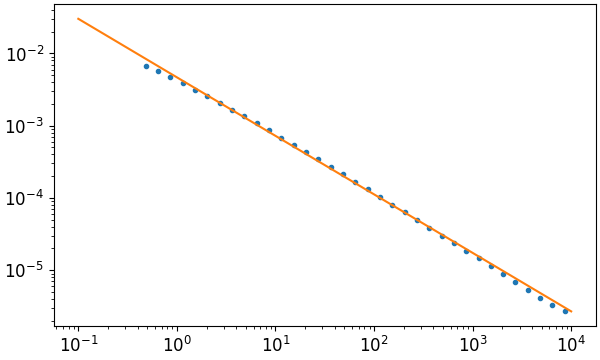

In [136]:
plt.figure()
plt.loglog(g_sfr[:-10],good_ratios[:-10],'.')
x = np.array([0.1,1,10,100,1000,10000])
plt.plot(x,powerlaw(x, 10**-2.33, -0.81))

### Radial Profile

In [256]:
#Just make sure never to call it "curve of growth". I guess it's kind of a "cumulative radial profile"
def curve_of_growth(image,start_coord,distance_grid):
    """Just like my other image utility, start_coord's x and y values are reversed from the numpy index order"""
    x,y = np.mgrid[0:image.shape[0],0:image.shape[1]]
    distance = np.sqrt((x-start_coord[1])**2+(y-start_coord[0])**2)
    growth_curve= []
    for d in distance_grid:
        circle_mask = distance < d
        growth_curve.append(np.sum(image[circle_mask]))
        
    return(np.array(growth_curve))
def plot_growth_curve(cube,center,distances,**kwargs):
    """only works on moment-0-type images"""
    growth = curve_of_growth(cube[0,:,:].value,center,distances)/cube.pixels_per_beam
    
    plt.plot(distances*get_pixel_scale(cube).to(units.arcsec),growth,**kwargs)
    plt.ylabel(f"Flux, {cube.unit*units.beam}")
    plt.xlabel(f"aperture radius, {units.arcsec}")
    
def plot_radial_profile(cube,center,distances,rms,**kwargs):
    """only works on moment-0-type images"""
    px_scale = get_pixel_scale(cube).to(units.arcsec)
    px_area=(distances[1:]**2-distances[:-1]**2)*np.pi
    area=px_area*px_scale**2
    growth = curve_of_growth(cube[0,:,:].value,center,distances)/cube.pixels_per_beam*cube.unit
    rad_prof = growth[1:]-growth[:-1]
    err=rms*np.sqrt(px_area/cube.pixels_per_beam)
    x=(distances*px_scale)[:-1]
    y=rad_prof/area
    e=err/area
    print(y.unit)
    print(e.unit)
    
    plt.errorbar(x.value,y.value,e.value,**kwargs)
    plt.ylabel(f"Flux, {cube.unit*units.beam}/arcsec$^2$")
    plt.xlabel(f"radial distance, {units.arcsec}")


Text(0.5, 1.0, 'Satellite component')

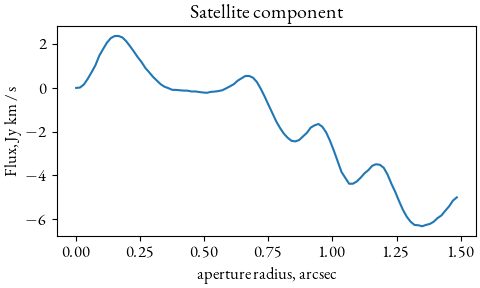

In [121]:
plt.figure()
distances = np.arange(0,100,1)
plot_growth_curve(linecube,(372,216),distances)
plt.title("Satellite component")

In [122]:
units.beam

Unit("beam")

Text(0.5, 1.0, 'Main component line')

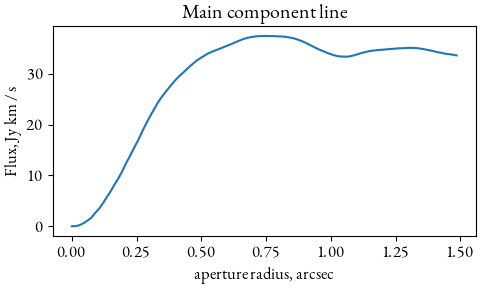

In [123]:
plt.figure()
plot_growth_curve(linecube,(250,250),distances)
plt.title("Main component line")

In [124]:
rms

<OneDSpectrum [0.00037049] Jy / beam>

Jy / (arcsec2 beam)
Jy / (arcsec2 beam)
Jy km / (arcsec2 beam s)
Jy km / (arcsec2 beam s)


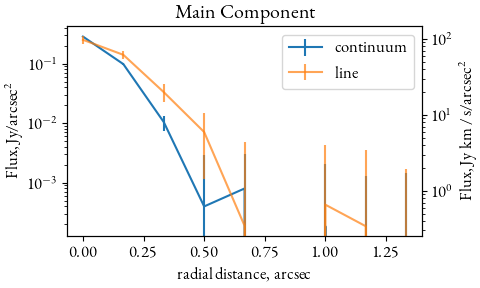

In [125]:
fig=plt.figure()
distances = np.linspace(0,100,10)
plot_radial_profile(contcube,(250,250),distances,rms,label="continuum")
plt.semilogy()
#plt.ylim(-0.04,0.4)
#plt.plot([0,0.5],[0,0])
plt.twinx()
plot_radial_profile(linecube,(250,250),distances,linerms,label="line",color="C1",alpha=0.7)
plt.title("Main Component")
ax=plt.gca()
plt.semilogy()
#plt.ylim(-15,150)
#plt.plot([0.2,1.4],[0,0])
fig.legend(bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)



Text(0.5, 1.0, 'satellite component')

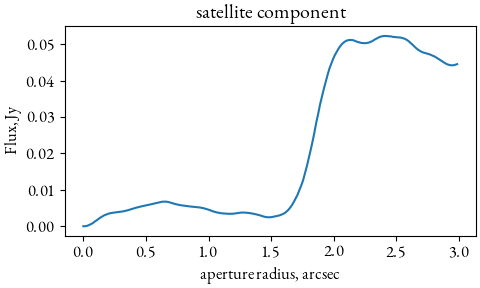

In [126]:
plt.figure()
distances = np.arange(0,200,1)
plot_growth_curve(contcube,(372,216),distances)
plt.title("satellite component")

## [CII] line cube

Load in line cube

In [140]:
ciicubefits = fits.open("../data/SDSSJ1000_CII_hires_pbcor.fits")
ciicube = SpectralCube.read(ciicubefits)[1:]#channel[0]==0 so leave it behind

In [141]:
s=ciicubefits[0].data.shape

In [142]:
z,x,y=np.meshgrid(np.arange(66),np.arange(512),np.arange(512),indexing='ij')

In [143]:
z.shape

(66, 512, 512)

In [144]:
ciicube

SpectralCube with shape=(65, 512, 512) and unit=Jy / beam:
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   150.157324 deg:  150.159455 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:     2.138492 deg:    2.140621 deg
 n_s:     65  type_s: FREQ      unit_s: Hz     range: 665963748019.187 Hz:673135674939.372 Hz

In [145]:
np.sum(ciicubefits[0].data)

63.12759

### Main component spectrum
Make a region. I used the same region that I used for extracting the flux, listed in the Central Info Repository. Then extract a sub-cube using that region.

Convenience function getmoment0 has destroyed your image's units. It hopefully returned mJy/beam.
112061358.1279 16


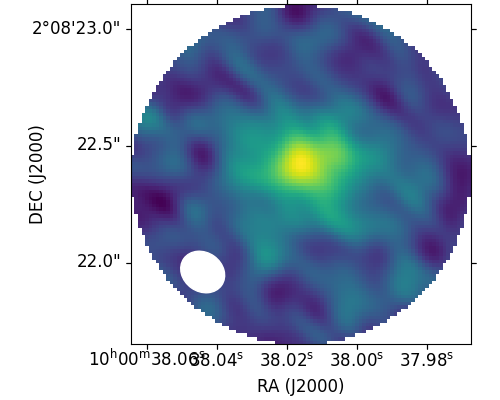

In [146]:
aperture_diameter = 1.451
subcube = extract_region(ciicube,"10:00:38.016 +2:08:22.377",aperture_diameter)
fig,ax=wcsfig(subcube,figsize=(5,4),elx=20,ely=20)
ax.imshow(getmoment0(subcube[19:3:-1]),origin="lower")

In [148]:
ciirms,ciirmscube = get_ds9_region_rms(ciicube,"../data/50kms-off-source-spectrum-region.reg") # This RMS will be in Jy/beam
rms_cube_2 = extract_region(ciicube,"10:00:37.95 +2:08:23.14",1.5)
rms_2 = np.sqrt((rms_cube_2*rms_cube_2).mean(axis=(1,2)))

(65, 88, 86)


In [149]:
main_spectrum = subcube.mean(axis=(1,2))

Text(0, 0.5, 'Flux density, Jy /beam')

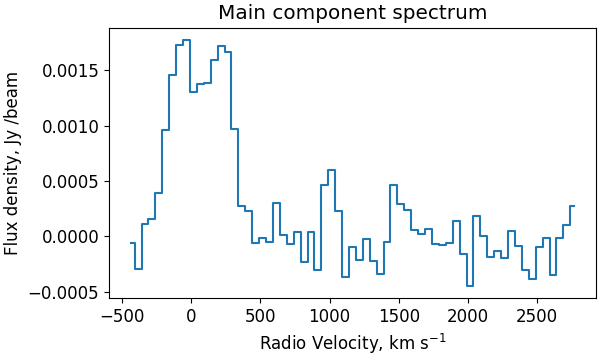

In [150]:
plt.figure()
doppler_convert = units.doppler_radio(CII_OBS)
velocity_axis = main_spectrum.spectral_axis.to("km/s", equivalencies=doppler_convert)
plt.step(velocity_axis,main_spectrum.array, where = "mid")
plt.xlabel("Radio Velocity, km s$^{-1}$")
plt.title("Main component spectrum")
plt.ylabel("Flux density, Jy /beam")

\convert rms from jy/beam to jy for the main component region.

In [151]:
rmsjy_main = rms_2.array*np.sqrt(total_beams(subcube))

In [152]:
lambda1=(50*units.km/units.s).to("um",equivalencies=doppler_convert)

In [153]:
lambda2=CII_OBS.to("um",equivalencies=units.spectral())

In [154]:
R = lambda2/(lambda1-lambda2)
R

<Quantity 5994.84916>

In [155]:
(1500 *units.km/units.s).to('GHz',equivalencies=doppler_convert)


<Quantity 668.79845691 GHz>

In [156]:
(2750 *units.km/units.s).to('GHz',equivalencies=doppler_convert) - (500 *units.km/units.s).to('GHz',equivalencies=doppler_convert)

<Quantity -5.04470189 GHz>

In [157]:
 6.7302361e11/(6.7313567e11- 6.7302361e11)

6005.92191683027

Text(0, 0.5, 'Flux density, Jy')

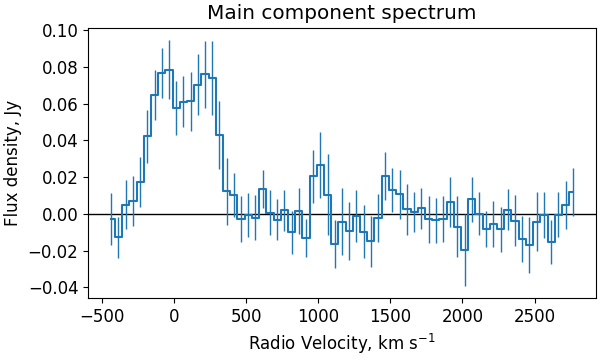

In [158]:
plt.figure()
plt.axhline(0,color='k',linewidth=1)
doppler_convert = units.doppler_radio(CII_OBS)
velocity_axis = main_spectrum.spectral_axis.to("km/s", equivalencies=doppler_convert)
spectrum_jy_main = main_spectrum.array*total_beams(subcube)
line=plt.step(velocity_axis,spectrum_jy_main, where = "mid")
lncolor = line[0].get_c()
plt.errorbar(velocity_axis.value,spectrum_jy_main,rmsjy_main,fmt="none",ecolor=lncolor,elinewidth=1)

plt.xlabel("Radio Velocity, km s$^{-1}$")
plt.title("Main component spectrum")
plt.ylabel("Flux density, Jy")

In [159]:
fit_result1 = curve_fit(two_gaussians,
                       velocity_axis,
                       spectrum_jy_main,
                       [0.075,200,100, 0.08, -50, 100]
                      ) 
fit_result = curve_fit(two_gaussians,
                       velocity_axis,
                       spectrum_jy_main,
                       fit_result1[0],
                       sigma=rmsjy_main,
                       absolute_sigma=True,
                       maxfev=67*200
                      ) 

In [160]:
perr = np.sqrt(np.diag(fit_result[1]))

In [161]:
for name,value,err in zip(["peak1","x01","sig1","peak2","x02","sig2"],fit_result[0],perr):
    if name[0:3]=="sig":
        value = value * 2 *np.sqrt(2*np.log(2))
        err = err * 2*np.sqrt(2*np.log(2))
        name = "fwhm"+name[3:]
    print(f"{name} = {value:.2e} +/- {err:.2e}")


peak1 = 7.75e-02 +/- 1.20e-02
x01 = 2.08e+02 +/- 2.85e+01
fwhm1 = 2.26e+02 +/- 5.84e+01
peak2 = 7.80e-02 +/- 9.90e-03
x02 = -7.11e+01 +/- 2.65e+01
fwhm2 = 2.32e+02 +/- 5.45e+01


In [162]:
(-71+208)/2

68.5

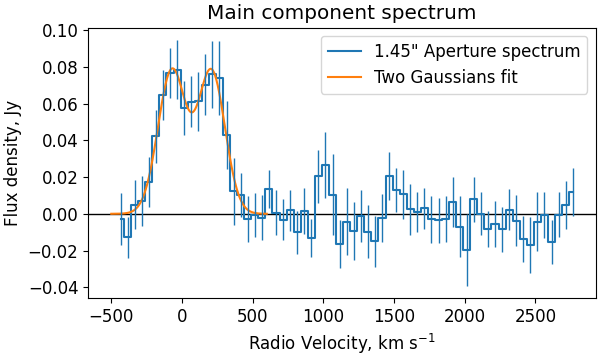

In [163]:
plt.figure()
plt.axhline(0,color='k',linewidth=1)
line=plt.step(velocity_axis,spectrum_jy_main, where = "mid",label="1.45\" Aperture spectrum")
plt.xlabel("Radio Velocity, km s$^{-1}$")
plt.title("Main component spectrum")
plt.ylabel("Flux density, Jy")
gaussian_x = np.linspace(-500,600,1000)
plt.plot(gaussian_x,two_gaussians(gaussian_x,*(fit_result[0])),label="Two Gaussians fit")
lncolor = line[0].get_c()
plt.errorbar(velocity_axis.value,spectrum_jy_main,rmsjy_main,fmt="none",ecolor=lncolor,elinewidth=1)
plt.legend()
#axvline(80)

savefig2("main_component_spectrum")

In [165]:
atmo = np.loadtxt("../data/alma_atmo_expanded.data",skiprows=5)
atmo_vel = (atmo[:,0]*units.GHz).to("km/s", equivalencies=doppler_convert)

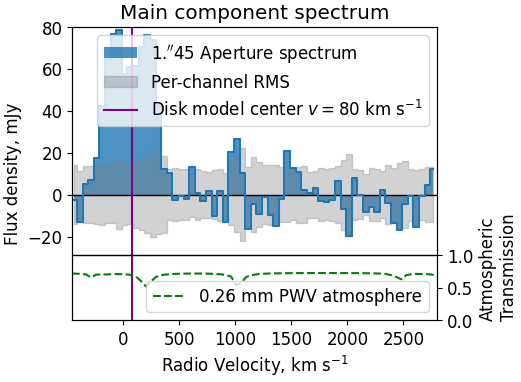

In [166]:
plt.figure(figsize=(6/1.15,4.4/1.15))#figsize=(7.5,5.5))
if FONT == 'dark':
    plt.axhline(0,color='w',linewidth=1)
else:
    plt.axhline(0,color='k',linewidth=1)
plt.fill_between(velocity_axis,
                 np.zeros_like(spectrum_jy_main),
                 spectrum_jy_main*1000,step='mid',
                 label=f"{aperture_diameter:.2f} Aperture spectrum".replace(".",r"$.^{\!\!\prime\prime}$"),
                 alpha=0.8)
plt.xlabel("Radio Velocity, km s$^{-1}$")
plt.title("Main component spectrum")
plt.ylabel("Flux density, mJy")
gaussian_x = np.linspace(-500,600,1000)

plt.fill_between(velocity_axis.value,-rmsjy_main*1000,rmsjy_main*1000,
                  color='gray',
                  alpha=0.35,step='mid',
                 label="Per-channel RMS")
plt.step(velocity_axis,spectrum_jy_main*1000, where = "mid",color='C0')
plt.axvline(80,label="Disk model center $v=80$ km s$^{-1}$",c="purple")
plt.legend(loc='upper right')
plt.ylim(-60,80)
plt.yticks([-20,0,20,40,60,80])
test=plt.twinx()
plt.plot(atmo_vel,atmo[:,1],'--',label="0.26 mm PWV atmosphere",c='g')
plt.ylim(0,4.5)
plt.ylabel("Atmospheric\nTransmission",loc='bottom')
x_ticks = np.append(ax.get_xticks(), 271)
plt.axhline(1,color='k',linewidth=1)

plt.yticks([0,0.5,1])
plt.legend(loc='lower right')#bbox_to_anchor=(1, 0.7))
plt.xlim(-450,2800)
savefig2("main_spectrum_with_atm")

"fit result" flux estimate

In [167]:
two_gaussians_integral(*fit_result[0])

37.861162886753434

In [168]:
two_gaussians_integral_error(*fit_result)

[2.89652123 4.81196668 2.44285868 4.52754984]
[ -8.47741379   2.54137086 -27.77024644  -3.88922054  -4.04275556
  -6.73384533]


3.104676119607045

Moment 0 aperture flux estimate

In [169]:
sum(spectrum_jy_main[2:19]*50)

37.67982031404972

In [170]:
mom0rms = np.sqrt(np.sum(ciirms.array[3:19]**2)) #in jy/beam
print(mom0rms*49.98)
mom0rms * np.sqrt(total_beams(subcube)) * 49.98

0.494143350161612


3.284634932835281

## Calculate Redshifts

In [171]:
#This is the conversion calculation for Riccardo's UVModelDisk velocity zero point 
# model vmax = -48
(673.094*units.GHz).to("km/s",equivalencies=doppler_convert)

<Quantity -415.86582246 km / s>

In [172]:
(673.016*units.GHz).to("km/s",equivalencies=doppler_convert)

<Quantity -381.07684906 km / s>

In [173]:
# image v_center = (image_vmax + image_vmin)/2
# Velocity Decreases as channel number Increases *IN IMAGES*
# Velocity Increases as channel number Increases *IN MODEL PARAMETERS*
# v_center_model_in_image_frame should be close to  +69 km/s
# ALSO always use the GHZ values to compute the offsets, because CASA gets the velocities wrong!

In [174]:
(381.07685 - 435.69375)/2 + 48 # This value and the two above it, I have NO idea where they came from. I thought they
# were from old model attempts, but I can't figure that out right now

20.691549999999978

In [175]:
def ghz_to_kms(ghz):
    return(ghz*units.GHz).to("km/s",equivalencies=doppler_convert)

In [176]:
high_vel=ghz_to_kms(671.102)
high_vel # This and low_vel are the edges of the UVModelDisk frequeny range

<Quantity 472.59103655 km / s>

In [177]:
low_vel = ghz_to_kms(672.977)
low_vel

<Quantity -363.68236236 km / s>

In [178]:
(high_vel+low_vel)/2

<Quantity 54.45433709 km / s>

In [179]:
# image formodeling final 
# model_vmax = -25
# chan0=671.102, chan30=672.977 GHz
center_vel=(high_vel+low_vel)/2 +25*units.km/units.s # WHEW 80 km/s is about what I expected!! It's kinda what I got from 
# early runs, as far as I can tell! And it agrees well with the two-gaussians fit

cvulim = center_vel + 2.5 *center_vel.unit
center_vel

<Quantity 79.45433709 km / s>

In [180]:
center_vel_uncert = 2.5 # km/s

**This is the redshift that I report as best for cii!**

In [181]:
new_z = CII_REST/center_vel.to("GHz",equivalencies=doppler_convert)-1
new_z2 = CII_REST/cvulim.to("GHz",equivalencies=doppler_convert)-1
new_z



<Quantity 1.82824957>

In [182]:
new_z2 - new_z

<Quantity 2.3591512e-05>

In [183]:
(CII_REST / (1+proposal_redshift)).to("km/s",equivalencies=doppler_convert)

<Quantity -159.12550936 km / s>

In [184]:
doppler_convert = units.doppler_radio(CII_OBS)

In [185]:
herschel_ref_wavelength=178.56 # micron
oi=63.18367 # micron
oi_freq=consts.c/oi/units.micron
oi_obs_freq = consts.c/herschel_ref_wavelength/units.micron
vel_center=-126.05897 * units.km/units.s #from the gaussian fit



In [186]:
doppler_oi = units.doppler_radio(oi_obs_freq)
oi_assumed_z = oi_freq/oi_obs_freq-1
oi_assumed_z

<Quantity 1.82604667>

In [187]:
vel_axis_offset=(oi_freq/(redshift_assumed+1)).to("km/s",equivalencies=doppler_oi)
vel_axis_offset

<Quantity 154.09313291 km / s>

In [188]:
(154*units.km/units.s).to("um",equivalencies=doppler_oi)

<Quantity 178.6517714 um>

In [189]:
oi*2.8275

178.651826925

This means that 154 km/s in the herschel spectrum is the location of the oi line at the assumed redshift 1.8275. So we have to subtract 154 km/s from the herschel spectrum x axis if we want it to be in the same reference frame as our other spectra.

In [190]:
herschel_best_z=oi_freq/vel_center.to('GHz',equivalencies=doppler_oi)-1
herschel_best_z

<Quantity 1.82485885>

## Satellite component spectrum

Convenience function getmoment0 has destroyed your image's units. It hopefully returned mJy/beam.
112061358.1279 10


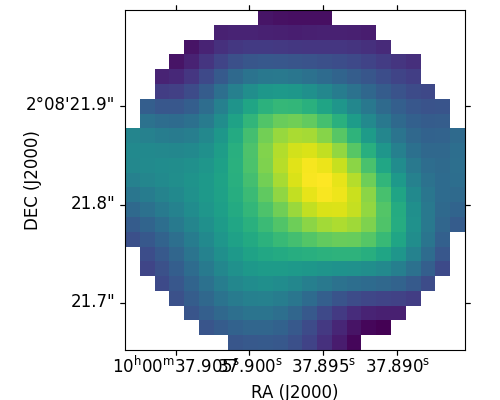

In [191]:
satcube = extract_region(ciicube,"10:00:37.897 +02:08:21.82",0.35)
fig,ax=wcsfig(satcube,figsize=(5,4))
ax.imshow(getmoment0(satcube[15:5:-1]),origin="lower")
ax.set_position([0.25,0.1,0.68,0.9])

In [192]:
satspec = satcube.mean(axis=(1,2))
rmsjy_sat = ciirms.array*np.sqrt(total_beams(satcube))

In [193]:
total_beams(satcube)

2.5467859200711715

Text(0, 0.5, 'Flux density, Jy')

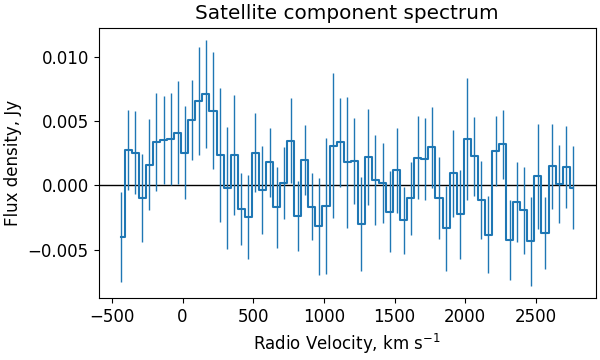

In [194]:
plt.figure()
plt.axhline(0,color='k',linewidth=1)
velocity_axis = satspec.spectral_axis.to("km/s", equivalencies=doppler_convert)
sat_spectrum_jy = satspec.array*total_beams(satcube)
line=plt.step(velocity_axis,sat_spectrum_jy, where = "mid")
lncolor = line[0].get_c()
plt.errorbar(velocity_axis.value,sat_spectrum_jy,rmsjy_sat,fmt="none",ecolor=lncolor,elinewidth=1)

plt.xlabel("Radio Velocity, km s$^{-1}$")
plt.title("Satellite component spectrum")
plt.ylabel("Flux density, Jy")

In [195]:
fit_result = curve_fit(two_gaussians,
                       velocity_axis,
                       sat_spectrum_jy,
                       [0.0045,-50,100, 0.006, 100, 100],
                       sigma=rmsjy_sat,
                       absolute_sigma=True,) 

In [196]:
perr = np.sqrt(np.diag(fit_result[1]))
for name,value,err in zip(["peak1","x01","sig1","peak2","x02","sig2"],fit_result[0],perr):
    if name[0:3]=="sig":
        value = value * 2 *np.sqrt(2*np.log(2))
        err = err * 2*np.sqrt(2*np.log(2))
        name = "fwhm"+name[3:]
    print(f"{name} = {value:.2e} +/- {err:.2e}")

peak1 = 3.68e-03 +/- 2.18e-03
x01 = -9.21e+01 +/- 1.89e+02
fwhm1 = 2.99e+02 +/- 3.85e+02
peak2 = 7.00e-03 +/- 4.65e-03
x02 = 1.60e+02 +/- 5.87e+01
fwhm2 = 1.68e+02 +/- 1.33e+02


In [197]:
np.average([-92.1,160],weights=[1/(189**2),1/(59**2)],returned=True)

(137.61440487730218, 0.0003152685088940711)

In [198]:
1/np.sqrt(0.0003152685088940711)

56.31961841487405

/var/folders/ck/hy5p5w_s1l12xprkbrgybk180000gn/T/ipykernel_12794/2383647112.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


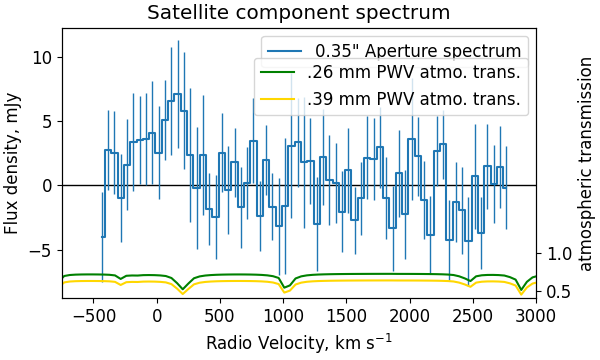

In [199]:
plt.figure()
plt.axhline(0,color='k',linewidth=1)
line=plt.step(velocity_axis,sat_spectrum_jy*1000, where = "mid",label="0.35\" Aperture spectrum")
lncolor = line[0].get_c()
plt.errorbar(velocity_axis.value,sat_spectrum_jy*1000,rmsjy_sat*1000,fmt="none",ecolor=lncolor,elinewidth=1)

plt.xlabel("Radio Velocity, km s$^{-1}$")
plt.title("Satellite component spectrum")
plt.ylabel("Flux density, mJy")
gaussian_x = np.linspace(-500,600,1000)
#plot(gaussian_x,two_gaussians(gaussian_x,*fit_result[0]),label="Two Gaussians fit")
plt.legend()
test=plt.twinx()
plt.plot(atmo_vel,atmo[:,1],label=".26 mm PWV atmo. trans.",c='g')
plt.plot(atmo_vel,atmo[:,2],label=".39 mm PWV atmo. trans.",c='gold')
plt.ylim(0.4,4)
plt.ylabel("atmospheric transmission")
x_ticks = np.append(ax.get_xticks(), 271)

# Set xtick locations to the values of the array `x_ticks`
plt.yticks([0.5,1])
plt.legend(bbox_to_anchor=(1, 0.92))
plt.xlim(-750,3000)
savefig2("sat_component_spectrum")

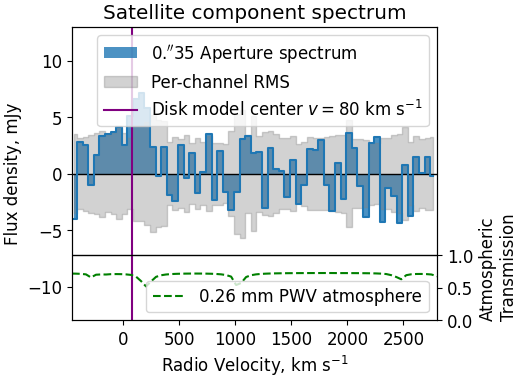

In [200]:
plt.figure(figsize=(6/1.15,4.4/1.15))#figsize=(7.5,5.5))
if FONT == 'dark':
    plt.axhline(0,color='w',linewidth=1)
else:
    plt.axhline(0,color='k',linewidth=1)
plt.fill_between(velocity_axis,
                 np.zeros_like(sat_spectrum_jy),
                 sat_spectrum_jy*1000,step='mid',
                 label="0.35 Aperture spectrum".replace(".",r"$.^{\!\!\prime\prime}$"),
                 alpha=0.8)
plt.xlabel("Radio Velocity, km s$^{-1}$")
plt.title("Satellite component spectrum")
plt.ylabel("Flux density, mJy")
gaussian_x = np.linspace(-500,600,1000)

plt.fill_between(velocity_axis.value,-rmsjy_sat*1000,rmsjy_sat*1000,
                  color='gray',
                  alpha=0.35,step='mid',
                 label="Per-channel RMS")
plt.step(velocity_axis,sat_spectrum_jy*1000, where = "mid",color='C0')
plt.axvline(80,label="Disk model center $v=80$ km s$^{-1}$",c="purple")
plt.legend(loc='upper right')
plt.ylim(-13,13)
#plt.yticks([-20,0,20,40,60,80])
test=plt.twinx()
plt.plot(atmo_vel,atmo[:,1],'--',label="0.26 mm PWV atmosphere",c='g')
plt.ylim(0,4.5)
plt.ylabel("Atmospheric\nTransmission",loc='bottom')
x_ticks = np.append(ax.get_xticks(), 271)
plt.axhline(1,color='k',linewidth=1)

plt.yticks([0,0.5,1])
plt.legend(loc='lower right')#bbox_to_anchor=(1, 0.7))
plt.xlim(-450,2800)
savefig2("sat_spectrum_with_atm")

In [201]:
(velocity_axis[1:] - velocity_axis[:-1])[0]

<Quantity 49.98076419 km / s>

In [202]:
two_gaussians_integral(*fit_result[0])

2.4272931382990413

In [203]:
two_gaussians_integral_error(*fit_result)

[0.69503002 1.5076127  0.83333645 0.98839486]
[-0.51846259  0.14091249 -1.80942     0.33672627 -0.25539156 -1.75192038]


0.7548384333303216

In [204]:
sum(sat_spectrum_jy[5:15]*49.98)

2.2124864608049393

In [205]:
mom0rms = np.sqrt(np.sum(ciirms.array[5:15]**2)) #in jy/beam
print(mom0rms*49.98)
mom0rms * np.sqrt(total_beams(satcube)) * 49.98

0.3981300964951515


0.6353619889586949

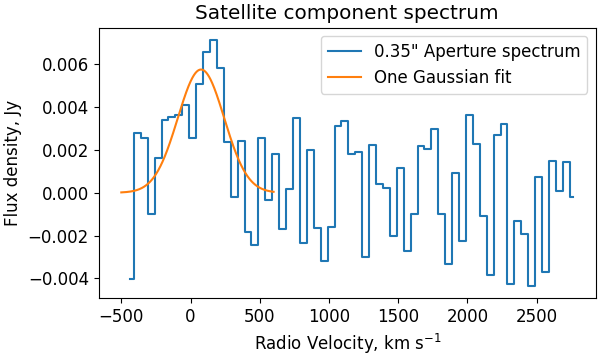

In [206]:
plt.figure()
one_gauss_fit = curve_fit(zt.gaussian,velocity_axis.value,sat_spectrum_jy,[150,0,0.006])
plt.step(velocity_axis.value,sat_spectrum_jy, where = "mid",label="0.35\" Aperture spectrum")
plt.xlabel("Radio Velocity, km s$^{-1}$")
plt.title("Satellite component spectrum")
plt.ylabel("Flux density, Jy")
gaussian_x = np.linspace(-500,600,1000)
plt.plot(gaussian_x,zt.gaussian(gaussian_x,*one_gauss_fit[0]),label="One Gaussian fit")
plt.legend()

In [207]:
one_gauss_fit

(array([1.67393549e+02, 7.58313659e+01, 5.75855153e-03]),
 array([[ 1.51018336e+03, -2.95284696e-01, -2.59691124e-02],
        [-2.95284696e-01,  1.50931381e+03,  4.61712911e-06],
        [-2.59691124e-02,  4.61712911e-06,  1.33923165e-06]]))

In [208]:
errs=np.sqrt(np.diag(one_gauss_fit[1])) # error bars
errs

array([3.88610778e+01, 3.88498882e+01, 1.15725177e-03])

In [209]:
center_vel

<Quantity 79.45433709 km / s>

In [210]:
center_vel_sat=one_gauss_fit[0][1] * units.km/units.s
cvsulim = center_vel_sat+errs[1] * units.km/units.s
cvsllim = center_vel_sat-errs[1] * units.km/units.s

In [211]:
center_vel_sat

<Quantity 75.83136589 km / s>

In [212]:
cvsulim - center_vel_sat

<Quantity 38.8498882 km / s>

In [213]:
center_vel-center_vel_sat

<Quantity 3.6229712 km / s>

In [214]:
sat_z = CII_REST/center_vel_sat.to("GHz",equivalencies=doppler_convert)-1
sat_z2 = CII_REST/cvsllim.to("GHz",equivalencies=doppler_convert)-1
# new_z
sat_z

<Quantity 1.82821539>

In [215]:
sat_z2-sat_z

<Quantity -0.00036655>

In [216]:
new_z2-new_z

<Quantity 2.3591512e-05>

In [217]:
cosmo.comoving_distance(sat_z)

<Quantity 4921.63366799 Mpc>

In [218]:
cosmo.comoving_distance(new_z)

<Quantity 4921.68717931 Mpc>

In [219]:
(cosmo.comoving_distance(new_z)-cosmo.comoving_distance(sat_z2))/(1+new_z)

<Quantity 0.22179743 Mpc>

### RMS calculations

In [220]:
regfile="../data/50kms-off-source-spectrum-region.reg"

In [221]:
rmsregion=regions.Regions.read(regfile,format="ds9")

In [222]:
rmscube = ciicube.subcube_from_regions(rmsregion)

Convenience function getmoment0 has destroyed your image's units. It hopefully returned mJy/beam.
-112061358.1279 65


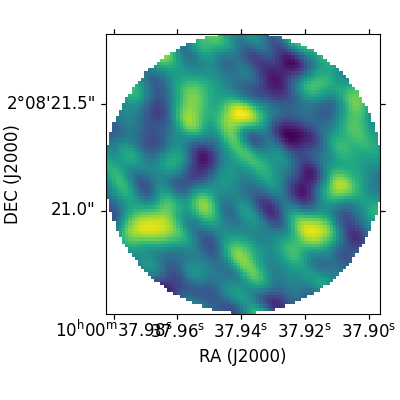

In [223]:
fig,ax=wcsfig(rmscube,figsize=(4,4))
ax.imshow(getmoment0(rmscube),origin='lower')
# ax.set_position([0.17,0.08,0.68,0.9])

In [224]:
square = rmscube*rmscube
meansquare = square.mean(axis=(1,2))
testrms = np.sqrt(meansquare)

In [226]:
casarms = np.loadtxt("../data/50kms-off-source-spectrum-fromfits.txt")

Verify that the RMSs I compute match reasonably well with the RMSs that CASA computes

## Moment 1 map

In [230]:
#first we convert our cube's spectral axis to km/s 
kmscube = ciicube.with_spectral_unit(units.km/units.s,
                                velocity_convention='radio',
                                rest_value=CII_OBS)  

#make a sub-cube that's just the part of the image we want to plot
sub_kmscube = kmscube[0:20,180:300,200:400]
moment_0 = sub_kmscube.moment(order=0)
# negative values mess up moment 1 and 2 maps,
# but I think they're necessary for moment_0 maps
# So at this point we mask them
mask_arr = sub_kmscube > 0 * sub_kmscube.unit # convention is opposite ma.array

sub_kmscube = sub_kmscube.with_mask(mask_arr)

moment_1 = sub_kmscube.moment(order=1)  
print(np.max(moment_0))
#calculate the rms from our rms cube above, using the same spectral channels
sigma=np.sqrt(np.sum(ciirms[0:20]**2))*50*units.km/units.s
print(sigma)
sigma = sigma.value


6.284181118011475 Jy km / (beam s)
0.5345355253666639 Jy km / (beam s)


In [231]:
def getmoment1(datacube,cutmap=None):
    """ Given a spectral cube, return the moment 1 map in km s^-1
    as a numpy array """
    kmscube = datacube.with_spectral_unit(units.km/units.s,
                                          velocity_convention='radio',
                                          rest_value=CII_OBS)
    moment1 = kmscube.moment(order=1)
    
    if cutmap is not None:
        moment1[cutmap]=np.nan
    
    return moment1.array

<class 'spectral_cube.lower_dimensional_structures.Projection'>
<class 'spectral_cube.lower_dimensional_structures.Projection'>
-81.61677306757178 km / s


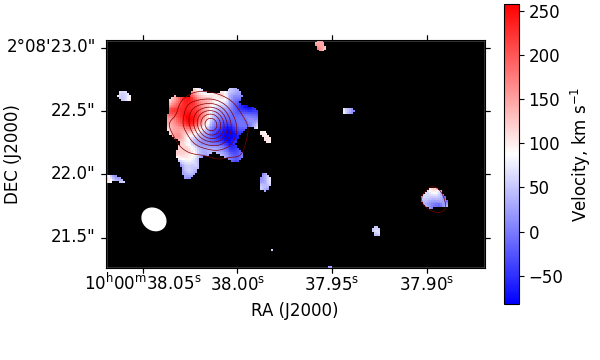

In [232]:
#remake moment 1 in case we want to play around with the sigma cut. (sigma cut overwrites the moment 1)
moment_1 = sub_kmscube.moment(order=1)  
fig,ax=wcsfig(sub_kmscube,elx=25,ely=25)
print(type(moment_1))
mom1 = moment_1
print(type(mom1))

mom1[moment_0.array<3.*sigma]=np.nan
print(np.nanmin(mom1))
im=ax.imshow((mom1.array),origin="lower",cmap="bwr")

# norm = matplotlib.colors.Normalize(vmin=-400+80, vmax=400+80)
# im.set_norm(norm)


cbar=fig.colorbar(im)
cbar.ax.set_ylabel("Velocity, km s$^{-1}$") #if we do colorbar after contour, we end up with a colorbar of the contours' colors
#ax.contour(moment_0.array,levels=np.arange(1,21,2)*sigma,colors="maroon",linewidths=1)
#black background for contrast with the white center of our moment 1 map
ax.contour(contimage[180:300,200:400]*1000,levels=np.arange(1.5,21.2,3),colors="maroon",linewidths=0.5)
ax.set_facecolor('k')
# xlim(200,400)
# ylim(200,300)
# cbar.ax.set_position([0.87,0.12,0.1,0.8])
# ax.set_position([0.17,0.08,0.68,0.9])
savefig2("moment_1_map")

<class 'spectral_cube.lower_dimensional_structures.Projection'>
<class 'spectral_cube.lower_dimensional_structures.Projection'>
-81.61677306757178 km / s


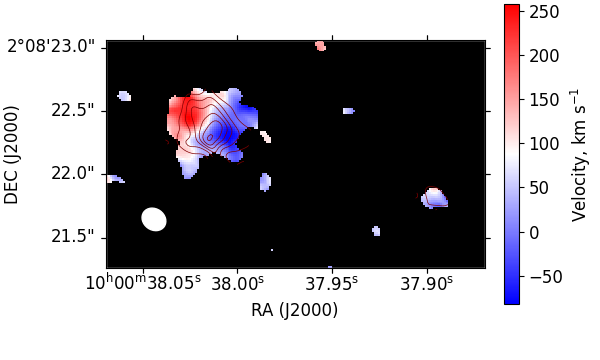

In [233]:
#remake moment 1 in case we want to play around with the sigma cut. (sigma cut overwrites the moment 1)
moment_1 = sub_kmscube.moment(order=1)  
fig,ax=wcsfig(sub_kmscube,elx=25,ely=25)
print(type(moment_1))
mom1 = moment_1
print(type(mom1))

mom1[moment_0.array<3.*sigma]=np.nan
print(np.nanmin(mom1))
im=ax.imshow((mom1.array),origin="lower",cmap="bwr")

# norm = matplotlib.colors.Normalize(vmin=-400+80, vmax=400+80)
# im.set_norm(norm)


cbar=fig.colorbar(im)
cbar.ax.set_ylabel("Velocity, km s$^{-1}$") #if we do colorbar after contour, we end up with a colorbar of the contours' colors
ax.contour(g0map[180:300,200:400],levels=np.array((2,4,6,8,10,12))*1000,colors="maroon",linewidths=0.5)
#black background for contrast with the white center of our moment 1 map
ax.set_facecolor('k')
# xlim(200,400)
# ylim(200,300)
# cbar.ax.set_position([0.87,0.12,0.1,0.8])
# ax.set_position([0.17,0.08,0.68,0.9])
savefig2("moment_1_map_FUV")

<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\s'
/var/folders/ck/hy5p5w_s1l12xprkbrgybk180000gn/T/ipykernel_12794/4184532859.py:17: SyntaxWarning: invalid escape sequence '\s'
  cbar.ax.set_ylabel("$\sigma$, km s$^{-1}$") #if we do colorbar after contour, we end up with a colorbar of the contours' colors


<class 'spectral_cube.lower_dimensional_structures.Projection'>
98.09569710840616 km / s


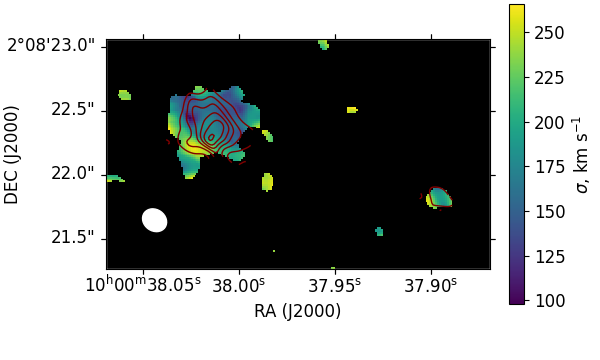

In [234]:

moment_2 = sub_kmscube.linewidth_sigma()

fig,ax=wcsfig(sub_kmscube,elx=25,ely=25)
print(type(moment_2))

mom2 = moment_2

mom2[moment_0.array<3.*sigma]=np.nan
print(np.nanmin(mom2))
im=ax.imshow((mom2.array),origin="lower")

# norm = matplotlib.colors.Normalize(vmin=-400+80, vmax=400+80)
# im.set_norm(norm)


cbar=fig.colorbar(im)
cbar.ax.set_ylabel("$\sigma$, km s$^{-1}$") #if we do colorbar after contour, we end up with a colorbar of the contours' colors
ax.contour(g0map[180:300,200:400],levels=np.array((2,4,6,8,10,12))*1000,colors="maroon",linewidths=1)
#black background for contrast with the white center of our moment 1 map
ax.set_facecolor('k')
# xlim(200,400)
# ylim(200,300)
# cbar.ax.set_position([0.87,0.12,0.1,0.8])
# ax.set_position([0.17,0.08,0.68,0.9])
savefig2("moment_2_map_FUV")

## UV Model Disk Images

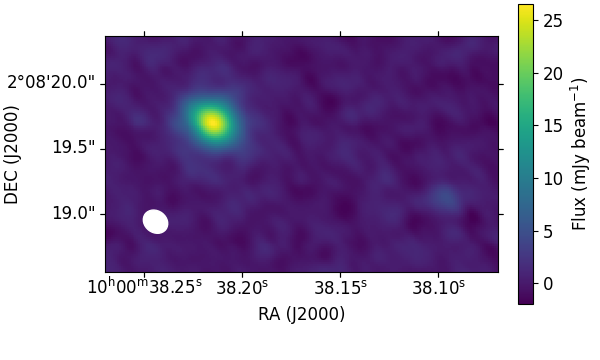

In [240]:
datafits = fits.open("../data/model_images/dataimage.fits")
datacube = SpectralCube.read(datafits)
fig,ax=wcsfig(datacube,elx=25,ely=25)
mom0=datacube.moment0()/(datacube.header["CDELT3"]*datacube.header["NAXIS3"]*units.Hz)*1000
im=ax.imshow(mom0.value[180:300,200:400],origin="lower")
cbar=plt.colorbar(im)
cbar.ax.set_ylabel("Flux (mJy beam$^{-1}$)")
# cbar.ax.set_position([0.87,0.20,0.05,0.65])
# ax.set_position([0.17,0.08,0.68,0.9])
savefig2("model_data")

In [241]:
mom0.value.shape

(512, 512)

Convenience function getmoment0 has destroyed your image's units. It hopefully returned mJy/beam.
62495572.0 31


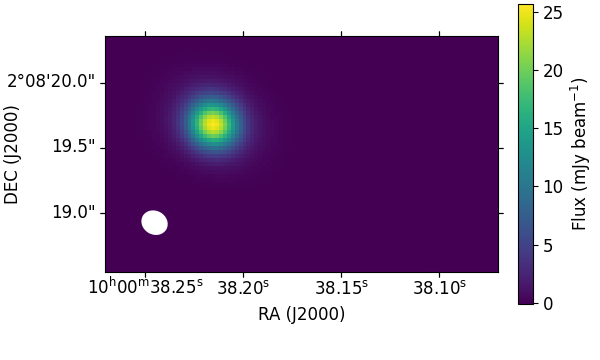

In [253]:
modelfits = fits.open("../data/model_images/model_image_pbcor.fits")
modelcube = SpectralCube.read(modelfits)
fig,ax=wcsfig(modelcube,elx=12,ely=12)
im=ax.imshow(getmoment0(modelcube)[180//2:300//2,200//2:400//2],origin="lower")
cbar=fig.colorbar(im)
cbar.ax.set_ylabel("Flux (mJy beam$^{-1}$)")
# cbar.ax.set_position([0.87,0.20,0.05,0.65])
# ax.set_position([0.17,0.08,0.68,0.9])
savefig2("model_model")

In [243]:
# modelfits[0].data = 0

Convenience function getmoment0 has destroyed your image's units. It hopefully returned mJy/beam.
62495572.0 31


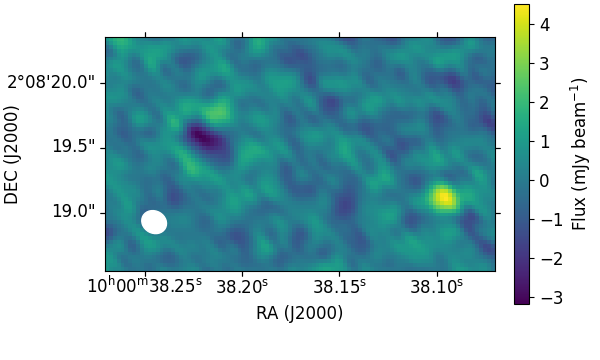

In [244]:
resfits = fits.open("../data/model_images/model_res_pbcor.fits")
rescube = SpectralCube.read(resfits)
fig,ax=wcsfig(rescube,elx=12,ely=12)
im=ax.imshow(getmoment0(rescube)[180//2:300//2,200//2:400//2],origin="lower")
cbar=fig.colorbar(im)
cbar.ax.set_ylabel("Flux (mJy beam$^{-1}$)")
# cbar.ax.set_position([0.87,0.20,0.05,0.65])
# ax.set_position([0.17,0.08,0.68,0.9])
savefig2("model_residuals")

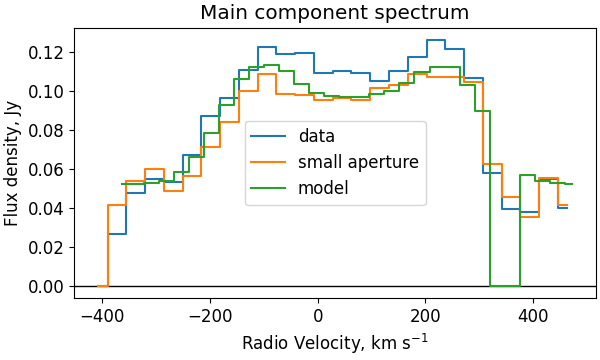

In [245]:
subdatacube = extract_region(datacube,"10:00:38.016 +2:08:22.377",1.45)
dataspectrum = subdatacube.mean(axis=(1,2))

tightdatacube = extract_region(datacube,"10:00:38.016 +2:08:22.377",.75)
tightdataspectrum = tightdatacube.mean(axis=(1,2))
tightjy = tightdataspectrum.array*total_beams(tightdatacube)

submodelcube = extract_region(modelcube,"10:00:38.016 +2:08:22.377",1.45)
modelspectrum = submodelcube.mean(axis=(1,2))
plt.figure()
plt.axhline(0,color='k',linewidth=1)
doppler_convert = units.doppler_radio(CII_OBS)
velocity_axis = dataspectrum.spectral_axis.to("km/s", equivalencies=doppler_convert)
spectrum_jy = dataspectrum.array*total_beams(subdatacube)

modeljy = modelspectrum.array*total_beams(submodelcube)

line=plt.step(velocity_axis,spectrum_jy, where = "mid",label="data")
lncolor = line[0].get_c()
#errorbar(velocity_axis.value,spectrum_jy,rmsjy_main,fmt="none",ecolor=lncolor,elinewidth=1)
plt.step(velocity_axis,tightjy, where = "mid",label="small aperture")
velocity_axis = modelspectrum.spectral_axis.to("km/s", equivalencies=doppler_convert)
plt.step(velocity_axis,modeljy, where = "mid",label="model")



plt.xlabel("Radio Velocity, km s$^{-1}$")
plt.title("Main component spectrum")

plt.ylabel("Flux density, Jy")
plt.legend()

Text(0, 0.5, 'Flux density, Jy')

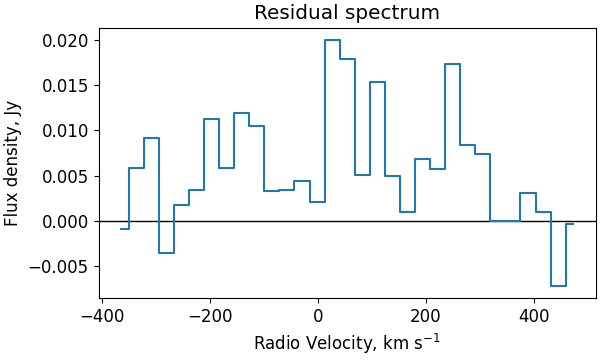

In [246]:
subrescube = extract_region(rescube,"10:00:38.016 +2:08:22.377",1)
resspectrum = subrescube.mean(axis=(1,2))
resjy = resspectrum.array*total_beams(subrescube)
plt.figure()
plt.axhline(0,color='k',linewidth=1)
plt.step(velocity_axis,resjy, where = "mid",label="real_res")
#step(velocity_axis,spectrum_jy-modeljy, where = "mid",label="calc_res")
#legend()
plt.xlabel("Radio Velocity, km s$^{-1}$")
plt.title("Residual spectrum")
plt.ylabel("Flux density, Jy")

Convenience function getmoment0 has destroyed your image's units. It hopefully returned mJy/beam.
62495572.0 31


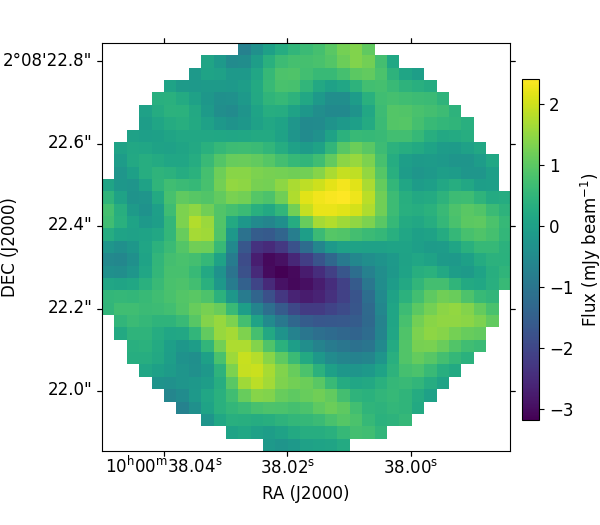

In [247]:
fig,ax=wcsfig(subrescube,figsize=(6,5.25))
im=ax.imshow(getmoment0(subrescube),origin="lower")
cbar=fig.colorbar(im)
cbar.ax.set_ylabel("Flux (mJy beam$^{-1}$)")
cbar.ax.set_position([0.87,0.20,0.05,0.65])
ax.set_position([0.17,0.08,0.68,0.9])
savefig2("model_reszoom")

Convenience function getmoment0 has destroyed your image's units. It hopefully returned mJy/beam.
78117255.24731 26


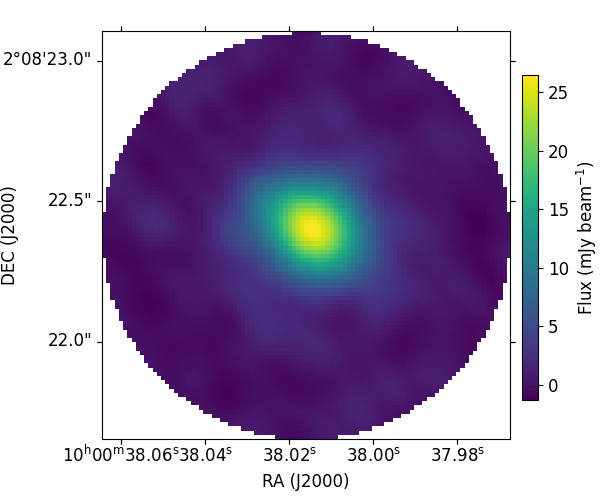

In [248]:
fig,ax=wcsfig(subdatacube,figsize=(6,5))
im=ax.imshow(getmoment0(subdatacube),origin="lower")

cbar=fig.colorbar(im)
cbar.ax.set_ylabel("Flux (mJy beam$^{-1}$)")
cbar.ax.set_position([0.87,0.20,0.05,0.65])
ax.set_position([0.17,0.08,0.68,0.9])
savefig2("model_datazoom")

Convenience function getmoment0 has destroyed your image's units. It hopefully returned mJy/beam.
78117255.24731 26


/Users/christopher/Library/CloudStorage/Dropbox/Documents/zeus2/SDSSJ1000/Rooney2025ApJ...987...61R/src/.venv/lib/python3.13/site-packages/spectral_cube/_moments.py:182: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /


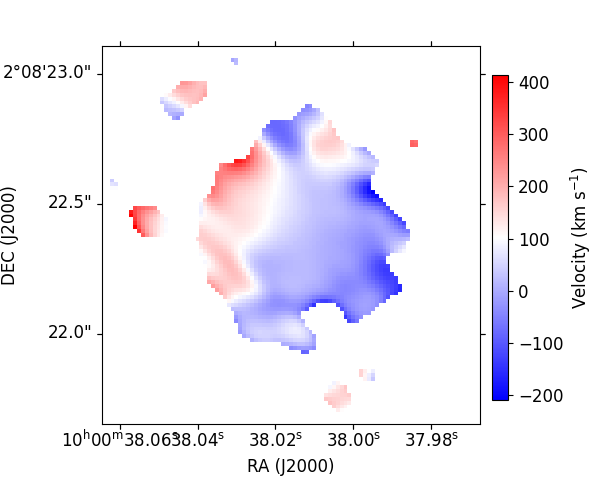

In [249]:
fig,ax=wcsfig(subdatacube,figsize=(6,5))
cut = getmoment0(subdatacube)<1
im=ax.imshow(getmoment1(subdatacube,cutmap = cut),origin="lower",cmap="bwr")

cbar=fig.colorbar(im)
cbar.ax.set_ylabel("Velocity (km s$^{-1}$)")
cbar.ax.set_position([0.82,0.20,0.05,0.65])
ax.set_position([0.17,0.08,0.63,0.9])
savefig2("model_datazoom_mom1")

The reason that the velocity center here is shifted is probably because this cube includes the continuum.

Convenience function getmoment0 has destroyed your image's units. It hopefully returned mJy/beam.
62495572.0 31


/Users/christopher/Library/CloudStorage/Dropbox/Documents/zeus2/SDSSJ1000/Rooney2025ApJ...987...61R/src/.venv/lib/python3.13/site-packages/spectral_cube/_moments.py:182: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /


Text(1.5, 1.5, 'Pepsi®')

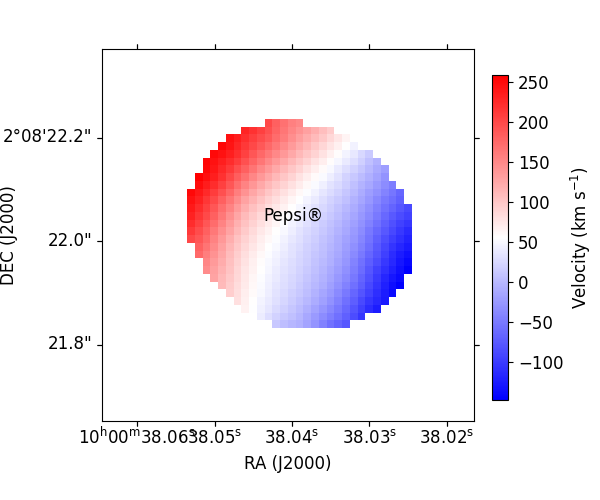

In [254]:
fig,ax=wcsfig(subdatacube,figsize=(6,5))
cut = getmoment0(submodelcube)<0.5
im=ax.imshow(getmoment1(submodelcube,cutmap = cut),origin="lower",cmap="bwr")
# vmin =-260
# vmax = 260
# norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
# im.set_norm(norm)

cbar=fig.colorbar(im)
cbar.ax.set_ylabel("Velocity (km s$^{-1}$)")
cbar.ax.set_position([0.82,0.20,0.05,0.65])
ax.set_position([0.17,0.08,0.62,0.9])

savefig2("model_modelzoom_mom1")
ax.annotate("Pepsi®",
                xy=(20, 25), xycoords='data',
                xytext=(1.5, 1.5), textcoords='offset points')


Convenience function getmoment0 has destroyed your image's units. It hopefully returned mJy/beam.
62495572.0 31


/Users/christopher/Library/CloudStorage/Dropbox/Documents/zeus2/SDSSJ1000/Rooney2025ApJ...987...61R/src/.venv/lib/python3.13/site-packages/spectral_cube/_moments.py:182: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /


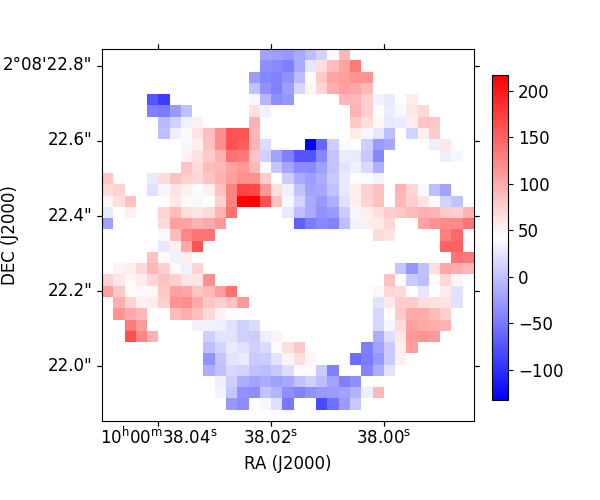

In [255]:
#absrescube = subrescube.apply_function(abs)
fig,ax=wcsfig(subrescube,figsize=(6,5))
cut = getmoment0(subrescube)<1
mask_arr = subrescube > 0 * subrescube.unit # convention is opposite ma.array

subrescube = subrescube.with_mask(mask_arr)

im = ax.imshow(getmoment1(subrescube,cutmap=cut),origin="lower",cmap="bwr")

#norm = matplotlib.colors.Normalize(vmin=-400, vmax=400)
#im.set_norm(norm)

cbar=fig.colorbar(im)
cbar.ax.set_position([0.82,0.20,0.05,0.65])
ax.set_position([0.17,0.08,0.62,0.9])
savefig2("model_reszoom_mom1")

No structure here! That's a good sign.

# Other Images

I found some cool other images, like VLA and Hubble that will be cool to incorporate somehow

In [256]:
HSTfits = fits.open("../data/archival_data/SDSSJ100_ACS_astrometric_calib30mas.fits")[0]
VLA3GHzfits = fits.open("../data/archival_data/0001_150.15833000_2.13944000_vla_3ghz_msmf.fits")[0]
WCS(VLA3GHzfits.header).dropaxis(3).dropaxis(2)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN' 'DEC--SIN' 
CRVAL : 150.119166668 2.20583333333 
CRPIX : 1456.0 1947.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -5.555555617e-05 5.555555617e-05 
NAXIS : 1501  1501

No beam found, not plotting beam ellipse


/var/folders/ck/hy5p5w_s1l12xprkbrgybk180000gn/T/ipykernel_12794/2704105914.py:2: RuntimeWarning: invalid value encountered in log
  im=ax.imshow(np.log(HSTfits.data+0.015),cmap='magma')


(200.0, 300.0)

/Users/christopher/Library/CloudStorage/Dropbox/Documents/zeus2/SDSSJ1000/Rooney2025ApJ...987...61R/src/.venv/lib/python3.13/site-packages/ipympl/backend_nbagg.py:335: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  self.figure.savefig(buf, format='png', dpi='figure')
/Users/christopher/Library/CloudStorage/Dropbox/Documents/zeus2/SDSSJ1000/Rooney2025ApJ...987...61R/src/.venv/lib/python3.13/site-packages/ipympl/backend_nbagg.py:335: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  self.figure.savefig(buf, format='png', dpi='figure')


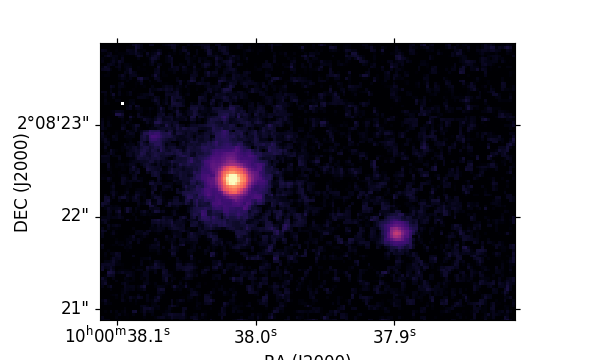

In [257]:
fig,ax=wcsfig(HSTfits)
im=ax.imshow(np.log(HSTfits.data+0.015),cmap='magma')

vmin = -4.2
vmax = 1.5

norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
im.set_norm(norm)

HSTfits.data.shape
ax.set_xlim(200,350)
ax.set_ylim(200,300)
# ax.set_position([0.18,0.09,0.72,0.9])

No beam found, not plotting beam ellipse


/var/folders/ck/hy5p5w_s1l12xprkbrgybk180000gn/T/ipykernel_12794/708165318.py:2: RuntimeWarning: invalid value encountered in log
  im=ax.imshow(np.log(HSTfits.data+0.015),cmap='magma')
/var/folders/ck/hy5p5w_s1l12xprkbrgybk180000gn/T/ipykernel_12794/148246775.py:109: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  plt.savefig(filename+".png",dpi=dpi,facecolor="#FFFFFF")
/var/folders/ck/hy5p5w_s1l12xprkbrgybk180000gn/T/ipykernel_12794/148246775.py:109: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  plt.savefig(filename+".png",dpi=dpi,facecolor="#FFFFFF")


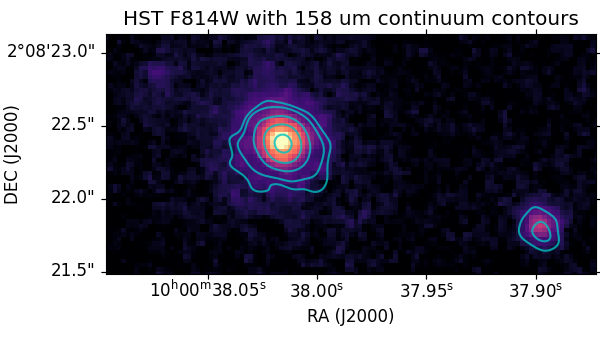

In [258]:
fig,ax=wcsfig(HSTfits)
im=ax.imshow(np.log(HSTfits.data+0.015),cmap='magma')

vmin = -4.2
vmax = 1.5

norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
im.set_norm(norm)
ax.set_xlim(208,320)
ax.set_ylim(220,275)

alma_transform = ax.get_transform(contcube.wcs.dropaxis(2))  
# allow for plotting two different images with different coordinate systems

# Overplot alma continuum
levels = np.array((2.5, 5, 15, 30,50))*rms.value  # Define contour levels to use
ax.contour(contimage, alpha=0.8, levels=levels,
           transform=alma_transform,colors='c')
ax.set_title("HST F814W with 158 um continuum contours")
# ax.set_position([0.18,0.09,0.72,0.9])
savefig2("hubble_continuum")

In [259]:
import scipy.interpolate as interp

In [260]:
#interp.interpn(

No beam found, not plotting beam ellipse


/var/folders/ck/hy5p5w_s1l12xprkbrgybk180000gn/T/ipykernel_12794/1746284153.py:2: RuntimeWarning: invalid value encountered in log
  im=ax.imshow(np.log(HSTfits.data+0.015),cmap='magma')


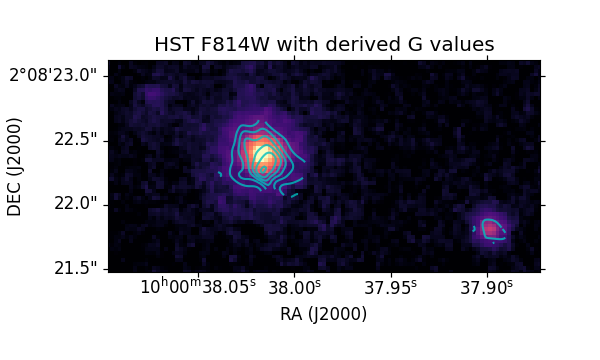

In [261]:
fig,ax=wcsfig(HSTfits)
im=ax.imshow(np.log(HSTfits.data+0.015),cmap='magma')

vmin = -4.2
vmax = 1.5

norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
im.set_norm(norm)

ax.set_xlim(208,320)
ax.set_ylim(220,275)

alma_transform = ax.get_transform(contcube.wcs.dropaxis(2))  
# allow for plotting two different images with different coordinate systems

# Overplot alma continuum
levels = np.array((2, 4, 6, 8, 10, 12))*1000  # Define contour levels to use
ax.contour(g0map, alpha=0.8, levels=levels,
           transform=alma_transform,colors='c')
ax.set_title("HST F814W with derived G values")
ax.set_position([0.18,0.09,0.72,0.9])
savefig2("hubble_g")


No beam found, not plotting beam ellipse


/var/folders/ck/hy5p5w_s1l12xprkbrgybk180000gn/T/ipykernel_12794/2896903958.py:2: RuntimeWarning: invalid value encountered in log
  im=ax.imshow(np.log(HSTfits.data+0.015),cmap='magma')


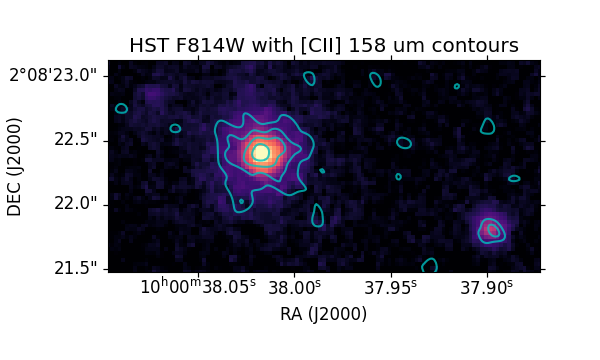

In [262]:
fig,ax=wcsfig(HSTfits)
im=ax.imshow(np.log(HSTfits.data+0.015),cmap='magma')

vmin = -4.2
vmax = 1.5

norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
im.set_norm(norm)


ax.set_xlim(208,320)
ax.set_ylim(220,275)

alma_transform = ax.get_transform(contcube.wcs.dropaxis(2))  
# allow for plotting two different images with different coordinate systems

# Overplot alma continuum
levels = np.array((2, 4, 6, 8))*linerms.value  # Define contour levels to use
ax.contour(lineimage, alpha=0.8, levels=levels,
           transform=alma_transform,colors='c')
ax.set_title("HST F814W with [CII] 158 um contours")
ax.set_position([0.18,0.09,0.72,0.9])
savefig2("hubble_line")
#fwhm/snr ~ localization

In [263]:
rms.value

array([0.00037049], dtype=float32)

In [264]:
np.min(HSTfits.data)

-0.02459057979285717

In [265]:
np.max(HSTfits.data)

8.543662071228027

In [266]:
f = HSTfits.data.flatten()
f.sort()
print(f)

[-0.02459058 -0.02153642 -0.02126679 ...  6.39847803  8.0794754
  8.54366207]


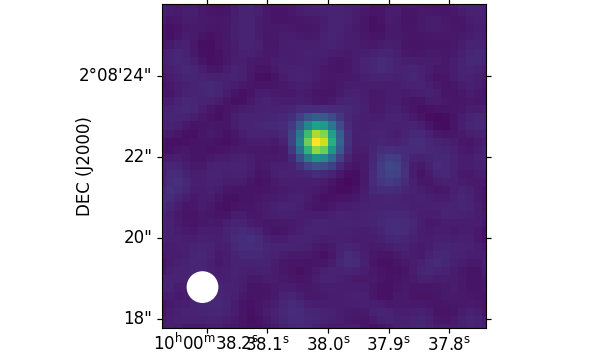

In [267]:
fig,ax=wcsfig(VLA3GHzfits,elx=735,ely=735)
im = ax.imshow(VLA3GHzfits.data)
ax.set_xlim(730,770)
ax.set_ylim(730,770)

vmin = np.min(VLA3GHzfits.data[730:770])
vmax = np.max(VLA3GHzfits.data[730:770])

norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
im.set_norm(norm)
ax.set_position([0.18,0.09,0.72,0.9])


In [268]:
VLA3GHzfits.data.shape

(1501, 1501)

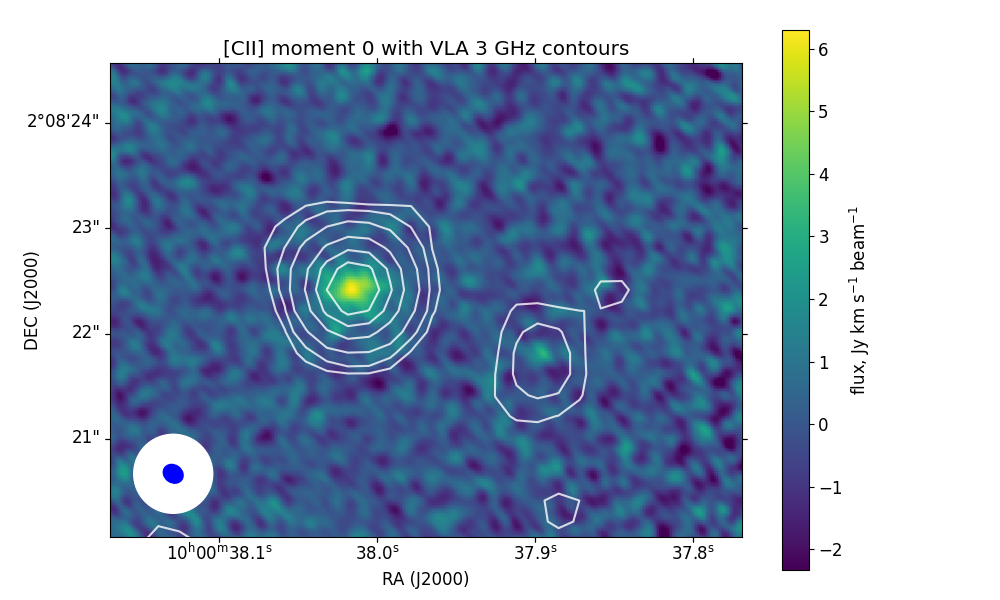

In [269]:
elx,ely= (140,140)
vlael=get_plot_ellipse(VLA3GHzfits,elx,ely,'w',target_wcs=linecube.wcs)
fig,ax=wcsfig(linecube,elx,ely,elc="b",figsize=(10,6),pre_el_patches = vlael)
im=ax.imshow(lineimage,origin="lower")

vmin = np.min(lineimage[180:300,200:400])
vmax = np.max(lineimage[180:300,200:400])

norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
im.set_norm(norm)
ax.set_xlim(100,500)
ax.set_ylim(100,400)
ax.set_position([0.11,0.05,0.79,0.9])
fig.colorbar(im,label="flux, Jy km s$^{-1}$ beam$^{-1}$")


ax.set_title("[CII] moment 0 with VLA 3 GHz contours")

vla_transform = ax.get_transform(get_wcs(VLA3GHzfits))  
levels = np.array((0.5,1,2,4,6,8))*1e-5  # Define contour levels to use
ax.contour(VLA3GHzfits.data, alpha=0.8, levels=levels,
           transform=vla_transform,colors='w')

savefig2('vla3ghz')

In [274]:
VLA20cmfits = fits.open("../data/archival_data/0001_150.15833000_2.13944000_vla_20cm_dp_sin_10.fits")[0]

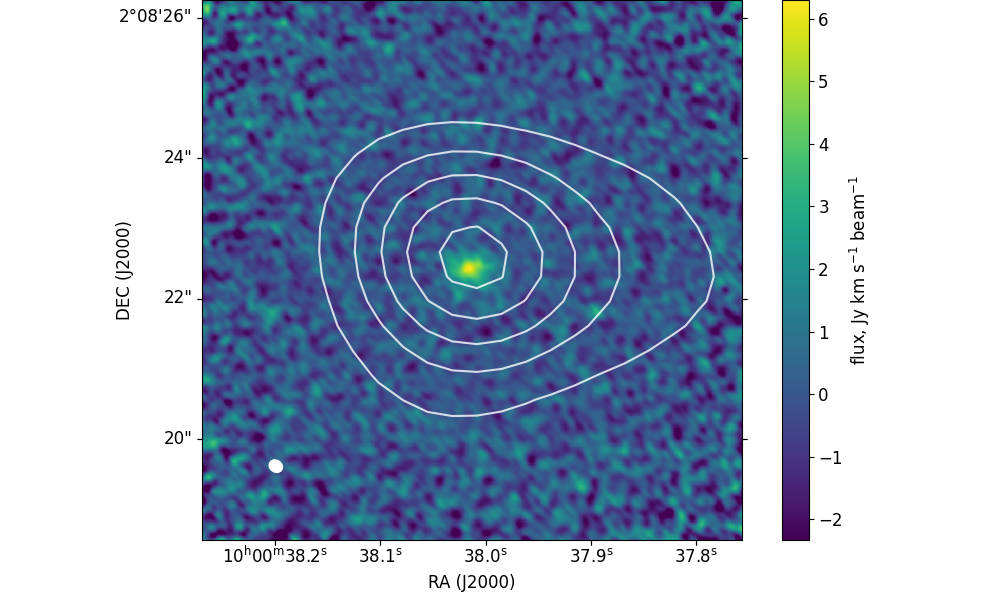

In [275]:
elx,ely= (70,70)
#vlael=get_plot_ellipse(VLA20cmfits,elx,ely,'k',target_wcs=linecube.wcs)
fig,ax=wcsfig(linecube,elx,ely,figsize=(10,6),)#pre_el_patches = vlael)
im=ax.imshow(lineimage,origin="lower")

vmin = np.min(lineimage[180:300,200:400])
vmax = np.max(lineimage[180:300,200:400])

norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
im.set_norm(norm)


ax.set_xlim(0,512)
ax.set_ylim(0,512)
ax.set_position([0.11,0.1,0.79,0.9])
ax.set_title("[CII] moment 0 with VLA 1.5 GHz contours")
fig.colorbar(im,label="flux, Jy km s$^{-1}$ beam$^{-1}$")
vla_transform = ax.get_transform(get_wcs(VLA20cmfits))  
levels = np.array((4,8,12,16,20,24))*1e-5  # Define contour levels to use
ax.contour(VLA20cmfits.data, alpha=0.8, levels=levels,
           transform=vla_transform,colors='w')
savefig2("vla1ghz")

In [276]:
vla90cmfits = fits.open("../data/archival_data/0001_150.15833000_2.13944000_COSMOS_VLA_90cm.fits")[0]

Text(80, 100, 'VLA 20 cm contour')

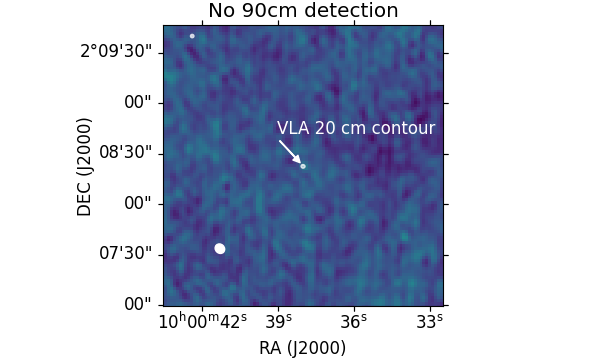

In [277]:
fig,ax=wcsfig(vla90cmfits,elx=60,ely=60)
ax.imshow(vla90cmfits.data)
ax.set_title("No 90cm detection")

alma_transform = ax.get_transform(contcube.wcs.dropaxis(2))  
# allow for plotting two different images with different coordinate systems

ax.set_xlim(40,138)
ax.set_ylim(40,138)
ax.set_position([0.11,0.15,0.79,0.78])
# Overplot alma continuum
vla_transform = ax.get_transform(get_wcs(VLA20cmfits))  
levels = np.array((16,))*1e-5  # Define contour levels to use
ax.contour(VLA20cmfits.data, alpha=0.8, levels=levels,
           transform=vla_transform,colors='w')
ax.annotate("VLA 20 cm contour",(88,90),(80,100),
            color='w',arrowprops={'color':'w','width':0.4,'headwidth':5,'headlength':5})

In [278]:
(90*units.cm).to("GHz", equivalencies=units.spectral())

<Quantity 0.33310273 GHz>

In [279]:
vla90cmfits.data.shape

(178, 178)

# Other calculations 

## Dynamical mass
$$M = \frac{RV^2}{G}$$

In [281]:
#(6.74e-7 * units.watt/units.m**2).to("erg/s")

In [282]:
ulim=(10*units.keV).to("Hz",equivalencies=units.equivalencies.spectral())
llim=(0.5*units.keV).to("Hz",equivalencies=units.equivalencies.spectral())

In [283]:
((6.74e-7*units.mJy*(ulim-llim)).to("W/m2")*cosmo.luminosity_distance(new_z)**2).to("erg/s")
                
            

<Quantity 2.85629086e+43 erg / s>

In [284]:

# obswavelength = (CII_REST*(1+new_z)).to("km",equivalencies = units.spectral())
# wm2 = jy_km_s * 10**-26 * units.watt/units.m**2/units.Jy/obswavelength*units.s
# lum = wm2 * 4 * np.pi * (cosmo.luminosity_distance(redshift))**2
# return lum.to("L_sun")


In [285]:
help(jy_km_s_to_lsun)

Help on function jy_km_s_to_lsun in module __main__:

jy_km_s_to_lsun(jy_km_s, redshift, restwavelength)
    Given a Quantity of Jy km s^-1, return a new
    Quantity containing the equivalent luminosity in
    L_sun. Requires the redshift of the source and the
    rest wavelength of the spectral line observed



In [286]:
consts.G

<<class 'astropy.constants.codata2018.CODATA2018'> name='Gravitational constant' value=6.6743e-11 uncertainty=1.5e-15 unit='m3 / (kg s2)' reference='CODATA 2018'>

In [287]:
R = 0.225* units.arcsec# arcsec, convert to kpc#FWHM from diskfit /2
V = 360 *units.km/units.s

In [288]:
#MRS
#freq = CII_OBS
smallest_baseline=15 *units.m
angular= consts.c/CII_OBS/smallest_baseline

In [289]:
(angular.to("")*units.rad).to("arcsec")

<Quantity 6.13311184 arcsec>

In [290]:
CII_OBS

<Quantity 672.16159151 GHz>

In [291]:
100/670

0.14925373134328357

In [292]:
1/6.7

0.14925373134328357

In [293]:
13.7/6.7

2.044776119402985

In [294]:
8.9/6.7

1.328358208955224

In [295]:
5*2.8275

14.137500000000001

other fluxes


In [296]:
xflx=9.47e-15*units.erg/units.s/units.cm**2

In [297]:
9.47-7.464

2.0060000000000002

In [298]:
11.36-9.47

1.8899999999999988

X ray flux $9.5\pm2.0$ erg s$^{-1}$ cm$^{-2}$

new x-ray flux from 2016ApJ...819...62C : 1.63e-14 mW/m^2 +/-1.3e-15

In [299]:
xflx2 = 1.63e-14 * units.mW / units.m**2
xflx2_e = 1.3e-15 * units.mW / units.m**2

In [300]:
(xflx * cosmo.luminosity_distance(new_z)**2).to("erg s-1")

<Quantity 1.74708705e+43 erg / s>

In [301]:
(xflx2* cosmo.luminosity_distance(new_z)**2).to("erg s-1")

<Quantity 3.00712976e+43 erg / s>

In [302]:
(xflx2_e * cosmo.luminosity_distance(new_z)**2).to("erg s-1")

<Quantity 2.39832435e+42 erg / s>

In [303]:
cosmo.luminosity_distance(1.9636)

<Quantity 15193.98258142 Mpc>

In [304]:
cosmo.luminosity_distance(1.8275)

<Quantity 13912.75258029 Mpc>

In [305]:
(8.67e-14*units.erg/units.s/units.cm**2 * cosmo.luminosity_distance(1.01)**2).to('erg s-1')

<Quantity 3.69403098e+43 erg / s>

In [306]:
np.log10(5.7e43)

43.75587485567249

In [307]:
63*2.8275

178.13250000000002

In [308]:
(consts.c/4744.77749000/units.GHz).to("um",equivalencies=units.spectral())*(2.82825)

<Quantity 178.69921638 um>

In [309]:
from zeustools import calibration
calibration.wm2_to_jy_km_s(1.6e-18*units.watt/units.m**2,178.69*units.micron)
# This is the value I get for [OI] flux from Steve HD's paper.

<Quantity 28.5904 Jy km / s>

In [310]:
0.6/1.6*28
# This is the uncertainty from steve hd's paper

10.499999999999998

In [311]:
consts.c/3.435452266982E+11*2.82825

<Quantity 0.00246805 m / s>

In [312]:
import datetime

In [313]:
cosmo.angular_diameter_distance(new_z)/206265

<Quantity 0.00843666 Mpc>

In [314]:
ang_scale=cosmo.arcsec_per_kpc_proper(new_z)**-1
ang_scale

<Quantity 8.43667157 kpc / arcsec>

In [315]:
(((57*units.km/units.s*3.8*units.kpc)**2)/(4*1.1e11*units.Msun*consts.G)).to("pc")

<Quantity 24.79151912 pc>

In [316]:
cosmo.H(1.82825)

<Quantity 191.53603947 km / (Mpc s)>

In [317]:
cosmo.H(0)

<Quantity 70. km / (Mpc s)>

In [318]:
from astropy.coordinates import SkyCoord

In [319]:
satpos = SkyCoord("10h00m38.01419s +02d08m22.3950s")
mainpos= SkyCoord("10h00m37.8964s +02d08m21.804s")

In [320]:
ang_dist=mainpos.separation(satpos)
ang_dist

<Angle 0.0005172 deg>

In [321]:
distance=(ang_dist*ang_scale).to('kpc')*np.sqrt(2)

In [322]:
uncerts=[0.003,0.003,0.015,0.015]
difference_uncert=np.sqrt(np.sum(np.array(uncerts)**2))

In [323]:
0.02/1.86*15.7

0.16881720430107525

kepler's 3rd law:
$$
P^2 = \frac{4\pi^2}{GM} a^3
$$

$r = a$

$t_{dyn} = P/2$

Note that the mass 3e11 msun came from the prospector fit that bo did. If we use the liu numbers instead that should be 1.5e11

In [324]:
p=np.sqrt(4*np.pi**2/consts.G/1.5e11/units.M_sun*(distance)**3)
p

<Quantity 207.92023868 kpc(3/2) s kg(1/2) / (solMass(1/2) m(3/2))>

In [325]:
p.to("yr")

<Quantity 8.00876703e+08 yr>

In [326]:
tdyn = p/2
tdyn.to("yr")

<Quantity 4.00438352e+08 yr>

In [327]:
plt.close("all")